## Maaslin 2 Analysis of GO Terms for COVIRT19

 Lets install some R packages that we are gonna need to run this analysis

#if(!requireNamespace("BiocManager", quietly = TRUE))
#install.packages("BiocManager")

In [1]:
#if (!requireNamespace("BiocManager", quietly = TRUE))
#BiocManager::install(c("Maaslin2", "DESeq2",'phyloseq','microbiome','DirichletMultinomial','GenomicRanges'))

In [2]:
#install.packages("remotes")
#remotes::install_github("mikemc/speedyseq")
#install.packages(c('circlize','ggpubr','viridis','mosaic'))

Now lets load our libraries and set out environment

In [3]:
library(tidyverse)
library(phyloseq)
library(microbiome)
library(DESeq2)
library(Maaslin2)
library(parallel)
library(DirichletMultinomial)
library(pheatmap)
library(ggpubr)
library(viridis)
library(mosaic)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


microbiome R package (microbiome.github.com)
    


 Copyright (C) 2011-2020 Leo Lahti, 
    Sudarshan Shetty et al. <microbiome.github.io>



Attaching package: ‘microbiome’


The following object is masked from ‘package:ggplot2’:

    alpha


The following object is masked from ‘package:base’:

    transform


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEv

In [4]:
'/home/jovyan/work/Aagaard_Raid3/microbial/GO_term_analysis/R_Maaslin2'

[1] "/home/jovyan/work/Aagaard_Raid3/microbial/GO_term_analysis/R_Maaslin2"

In [5]:
getwd()
setwd('/home/jovyan/work/Aagaard_Raid3/microbial/GO_term_analysis')

[1] "/home/jovyan/work/Aagaard_Raid3/microbial/GO_term_analysis/R_Maaslin2"

In [6]:
raw<-as_tibble(read.table("Combined_BALF_GO_Terms_parent_propagated.tsv", sep = "\t", row.names = NULL, header = T, quote = "", comment.char = ""))

A tibble: 47,233 x 2,020     # good so far now
do a little regex and fix some stuff

In [7]:
colnames(raw)<-gsub("NA_tax","unclass", colnames(raw))%>%str_replace_all("NC1_SRR7796663", "NC1.SRR7796663")

Transform the raw table by type of count (euk, term, bac, arc)

In [8]:
df<-raw %>%
  select(GO_term,namespace,depth,name,ends_with("_counts"))%>%
  pivot_longer(cols = -c(GO_term,namespace,depth,name),
               names_to =  c("sample","type","abund"),#c("Total", "Archaea","Bacteria","Eukarya", "Viridae", "Unclassified"),
               names_pattern = "(.*)_(.*)_(.*)")%>%
  select(-abund)%>%
  filter(value>1)%>%
  pivot_wider(names_from = sample, values_from=value, values_fill=0)
#SIDE NOTE:There are multiple processes and values for a single sample so you cant convert the sample to columns

Make individual tibbles for biological processes and molecular fxn

In [9]:
bio<-filter(df, namespace=="biological_process")
mol<-filter(df, namespace=="molecular_function")

make individual tibbles for each type (bac, euk, term, arc, vir, etc)

In [10]:
bio_bac<-bio%>%filter(type=="bac")%>%select(-type)
bio_term<-bio%>%filter(type=="term")%>%select(-type)
mol_bac<-mol%>%filter(type=="bac")%>%select(-type)
mol_term<-mol%>%filter(type=="term")%>%select(-type)

subselect tibbles for only the counts and go terminology

In [11]:
bio_bac_counts<-bio_bac%>%select(-c(namespace,depth,name))
bio_bac_tax<-bio_bac%>%select(GO_term,namespace,depth,name)
mol_bac_counts<-mol_bac%>%select(-c(namespace,depth,name))
mol_bac_tax<-mol_bac%>%select(GO_term,namespace,depth,name)

convert them to dataframes for downstream import to phylsoeq

In [12]:
bio_bac_counts<-data.frame(bio_bac_counts, row.names=1)
bio_bac_tax<-data.frame(bio_bac_tax, row.names=1)
mol_bac_counts<-data.frame(mol_bac_counts, row.names=1)
mol_bac_tax<-data.frame(mol_bac_tax, row.names=1)

convert the dataframes into phyloseq formats

In [13]:
bio_bac_counts_phy <- otu_table(bio_bac_counts, taxa_are_rows=TRUE)
bio_bac_tax_phy <- tax_table(as.matrix(bio_bac_tax), errorIfNULL=TRUE)
mol_bac_counts_phy<-otu_table(mol_bac_counts, taxa_are_rows = T)
mol_bac_tax_phy<-tax_table(as.matrix(mol_bac_tax), errorIfNULL = T)

import your metadata

In [14]:
bio_bac_sam<-as.data.frame(read.table("Combined_BALF_GO_Terms_metadata2.txt",header = T, sep = "\t",row.names = 1))

a little regex to fix the stupid filename

In [15]:
rownames(bio_bac_sam)<-rownames(bio_bac_sam)%>%str_replace_all("NC1_SRR7796663", "NC1.SRR7796663")
bio_bac_sam$accession<-rownames(bio_bac_sam)

I want to take a moment and thank the curators for all their hard work in annotation the metadata........ =)

In [16]:
bio_bac_sam$outcome<-bio_bac_sam$outcome%>%
str_replace_all("recovered", "Recovered")%>%
str_replace_all("deceased","Deceased")%>%
str_replace_all('stabilized',"Stabilized")
###DONT FORGET TO DELETE THESE LINES LATER AFTER YOUR DONE PLAYING AROUND
#str_replace_all('Stabilized',"Survived")%>%
#str_replace_all("Recovered", "Survived")
###############################################

In [17]:
bio_bac_sam$sex<-bio_bac_sam$sex%>%
str_replace_all("M", "male")%>%
str_replace_all("F", "female")%>%
str_replace_all("na", "<NA>")
tally(~sex,bio_bac_sam)

sex
  <NA> female   male   <NA> 
    22     54     61     30 

In [18]:
tally(~case,bio_bac_sam,format = "data.frame")
tally(~sample_type,bio_bac_sam,format = "data.frame")
tally(~outcome,bio_bac_sam, format = "data.frame")
tally(~publication, bio_bac_sam, format="data.frame")

case                         Freq
1 Community_acquired_pneumonia 25  
2 Control_Healthy              32  
3 Control_Neg                   5  
4 Control_Sick                 36  
5 Control_Unknown              21  
6 COVID19                      48

sample_type                  Freq
1  Asthma                        7  
2  Asthma_Ex_smoker              3  
3  Asthma_Smoker                 2  
4  Community_acquired_pneumonia 25  
5  COVID_19                     48  
6  Healthy                      32  
7  neg_control                   5  
8  Obese                         6  
9  Obese_Asthma                  9  
10 Obese_Asthma_Smoker           1  
11 Obese_Smoker                  5  
12 Smoker                        3  
13 Unknown                      21

outcome    Freq
1 Deceased    20 
2 Recovered   11 
3 Stabilized   8 
4 NA         128

making physeq object

In [19]:
bio_bac_pseq <- phyloseq(bio_bac_counts_phy, bio_bac_tax_phy, sample_data(bio_bac_sam))
mol_bac_pseq<-phyloseq(mol_bac_counts_phy,mol_bac_tax_phy, sample_data(bio_bac_sam))
bac_pseq<-merge_phyloseq(bio_bac_pseq,mol_bac_pseq)
bac_pseq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 13846 taxa and 167 samples ]
sample_data() Sample Data:       [ 167 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 13846 taxa by 3 taxonomic ranks ]

In [20]:
filtme<-c("GO:0003674")
bac_pseq <- prune_taxa(taxa=taxa_names(bac_pseq)!=filtme, bac_pseq)
filtme<-c("GO:0008150")
bac_pseq <- prune_taxa(taxa=taxa_names(bac_pseq)!=filtme, bac_pseq)
bac_pseq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 13844 taxa and 167 samples ]
sample_data() Sample Data:       [ 167 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 13844 taxa by 3 taxonomic ranks ]

filter out the negative control and unknown samples

In [21]:
bac_pseq_no_neg<-subset_samples(bac_pseq, sample_type!="neg_control")
bac_pseq_no_neg# [ 13846 taxa and 162 samples ]:
bac_pseq_no_neg<-subset_samples(bac_pseq_no_neg, sample_type!="Unknown")
bac_pseq_no_neg# [ 13846 taxa and 141 samples ]:

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 13844 taxa and 162 samples ]
sample_data() Sample Data:       [ 162 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 13844 taxa by 3 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 13844 taxa and 141 samples ]
sample_data() Sample Data:       [ 141 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 13844 taxa by 3 taxonomic ranks ]

Lets change the names of the Go Terms so we can understand the description as well as the tag

This code was causing mismatches with name and GO TAG and has since been resolved 19 NOV 2020

In [22]:
#names<-paste(taxa_names(bac_pseq_no_neg),get_taxa_unique(bac_pseq_no_neg,taxonomic.rank = "name" ),sep = "-")
#taxa_names(bac_pseq_no_neg)<-names

NEW and improved code

In [23]:
tax<-data.frame(tax_table(bac_pseq_no_neg))
names<-paste(rownames(tax),tax$name,sep="-")
length(names)
taxa_names(bac_pseq_no_neg)<-names

[1] 13844

# DESeq2 VST transformation

In [124]:
sample_info_tab<-sample_data(bac_pseq_no_neg)
sample_info_tab_phy <- sample_data(sample_info_tab)
deseq_counts<-phyloseq_to_deseq2(physeq = bac_pseq_no_neg,design = ~ 1) 
deseq_counts_vst <- estimateSizeFactors(deseq_counts, type = "poscounts")
vst_trans_count_tab <- assay(deseq_counts_vst)

converting counts to integer mode



#YAAAAAAAAAAAAAAAASSSSSSSSSSSSS THANK YOU LIMMMA

Dont worry about the limma batch effect correction step, I think I found a better way by including it in the multivariate model 

In [125]:
#vst_trans_count_tab2 <- limma::removeBatchEffect(vst_trans_count_tab, sample_info_tab$publication)

IT FIXED THE BATCH EFFECT!

### convert the normalized counts to a phyloseq object and transform into relative abundances

In [126]:
vst_count_phy <- otu_table(vst_trans_count_tab, taxa_are_rows=T)
vst_tax_phy <- tax_table(bac_pseq_no_neg)
vst_physeq <- phyloseq(vst_count_phy, vst_tax_phy,sample_data(bac_pseq_no_neg))
vst_physeq_comp<-microbiome::transform(x = vst_physeq,transform = "compositional")

# MaAsLIN2

In [133]:
sample_sums(vst_count_phy )

CRR125941      CRR125949    SRR11092059    SRR11092060    SRR11092061 
      16447412        9577437      206151642       17443596       18773278 
   SRR11092062      CRR125979    SRR10571655    SRR10571656    SRR10571657 
       7527021       18924981        1977029        1414201        1812624 
   SRR10571658    SRR10571659    SRR10571660    SRR10571662    SRR10571663 
       1669088        1834808        1999464        2126416        2861721 
   SRR10571664    SRR10571665    SRR10571719    SRR10571720    SRR10571721 
       3245945        2758187        1970541        2435638        1649522 
   SRR10571722    SRR10571723    SRR10571724    SRR10571725    SRR10571726 
       1920555        2076977        1881904        1913312        2128679 
   SRR10571727    SRR10571728    SRR10571730    SRR10571731    SRR10571732 
       1502623        1868834        1889429        2259251        2313511 
   SRR10571734    SRR10571735    SRR10571736    SRR10571737    SRR10571738 
       2326831        2015953        1851751        1550513        1896393 
   SRR10571739    SRR10571741    SRR10571742    SRR10571743    SRR10571744 
       2078374        1817680        2223277        2087722        2103254 
   SRR10571752    SRR10571753    SRR10571754    SRR10571755    SRR10571756 
       2123536        1732378        1976572        1975763        1860159 
   SRR10571757      CRR125993     SRR5677655      CRR125952      CRR125963 
       2138366        2280291        1690074        4147050         436859 
   SRR11092063      CRR125947      CRR125943    SRR10971381      CRR119894 
       2383358       96027463      327689672       68141495         643206 
     CRR119895      CRR119896      CRR119897      CRR125934      CRR125935 
        247831         141748          55554        2091353       17398239 
     CRR125936      CRR125937      CRR125938      CRR125939      CRR125940 
       1004639         441144         611456      131682601       96966405 
     CRR125942      CRR125944      CRR125945      CRR125946      CRR125948 
      28439005       22305705       11448628         187103       57018619 
     CRR125950      CRR125951      CRR125953      CRR125954      CRR125955 
        649493         160531         557477         998170        4149350 
     CRR125956      CRR125957      CRR125958      CRR125959      CRR125960 
      11426318        1217524        1299097         196618        1900238 
     CRR125961      CRR125962      CRR125964      CRR125965      CRR125966 
      18003495        1040969        1798735         672557        3183171 
     CRR125967      CRR125968      CRR125969      CRR125970      CRR125971 
       2471963        5091665         431865        3389844        1939837 
     CRR125972      CRR125973      CRR125974      CRR125975      CRR125976 
       3225942       85063214      117851584        1345138        1403852 
     CRR125977      CRR125978      CRR125980      CRR125981      CRR125982 
     285330752       16051844       60094225       10472146        6668715 
     CRR125983      CRR125984      CRR125985      CRR125986      CRR125987 
       3456434        3183922         165761         752649         156702 
     CRR125988      CRR125989      CRR125990      CRR125991      CRR125992 
      70010720        2082452       96803924        3591407       49956800 
     CRR125994    SRR10903401    SRR10903402 SRR11059940_PE SRR11059940_SE 
       2342760          55447         247713             77             95 
SRR11059941_PE SRR11059941_SE SRR11059942_PE SRR11059942_SE SRR11059943_PE 
           422             18           2084           2776             10 
SRR11059943_SE SRR11059944_PE SRR11059944_SE SRR11059945_PE SRR11059945_SE 
           616          29926           3360           4243            871 
SRR11059946_PE SRR11059946_SE SRR11059947_PE SRR11059947_SE    SRR11092056 
        275200            853         866163          34993         213003 
   SRR11092057    SRR11092058    SRR11092064     SRR5

In [123]:
head(abundances(vst_physeq))
head(abundances(bac_pseq_no_neg))

CRR125941
GO:0045212-obsolete neurotransmitter receptor biosynthetic process                                                           0   
GO:0001319-obsolete inheritance of oxidatively modified proteins involved in replicative cell aging                          0   
GO:1900008-obsolete negative regulation of extrachromosomal rDNA circle accumulation involved in replicative cell aging      0   
GO:0001302-obsolete replicative cell aging                                                                                   0   
GO:0051704-multi-organism process                                                                                          515   
GO:0008152-metabolic process                                                                                            576564   
                                                                                                                        CRR125949
GO:0045212-obsolete neurotransmitter receptor biosynthetic process                                                           0   
GO:0001319-obsolete inheritance of oxidatively modified proteins involved in replicative cell aging                          0   
GO:1900008-obsolete negative regulation of extrachromosomal rDNA circle accumulation involved in replicative cell aging      0   
GO:0001302-obsolete replicative cell aging                                                                                   0   
GO:0051704-multi-organism process                                                                                          430   
GO:0008152-metabolic process                                                                                            339887   
                                                                                                                        SRR11092059
GO:0045212-obsolete neurotransmitter receptor biosynthetic process                                                            0    
GO:0001319-obsolete inheritance of oxidatively modified proteins involved in replicative cell aging                           5    
GO:1900008-obsolete negative regulation of extrachromosomal rDNA circle accumulation involved in replicative cell aging       3    
GO:0001302-obsolete replicative cell aging                                                                                    4    
GO:0051704-multi-organism process                                                                                         13393    
GO:0008152-metabolic process                                                                                            6076651    
                                                                                                                        SRR11092060
GO:0045212-obsolete neurotransmitter receptor biosynthetic process                                                           0     
GO:0001319-obsolete inheritance of oxidatively modified proteins involved in replicative cell aging                          0     
GO:1900008-obsolete negative regulation of extrachromosomal rDNA circle accumulation involved in replicative cell aging      0     
GO:0001302-obsolete replicative cell aging                                                                                   2     
GO:0051704-multi-organism process                                                                                         1114     
GO:0008152-metabolic process                                                                                            508952     
                                                                                                                        SRR11092061
GO:0045212-obsolete neurotransmitter receptor biosynthetic process                                                           0     
GO:0001319-obsolete inheritance of oxidatively modified proteins involved in replicative cell aging                          0     
GO:1900008-obsolete negative regulation of extrachromoso

CRR125941 CRR125949 SRR11092059 SRR11092060 SRR11092061 SRR11092062
GO:0045212      0         0          0          0           0           0     
GO:0001319      0         0          5          0           0           2     
GO:1900008      0         0          3          0           0           0     
GO:0001302      0         0          4          2           0           3     
GO:0051704    515       430      13393       1114        1215         443     
GO:0008152 576564    339887    6076651     508952      551840      226458     
           CRR125979 SRR10571655 SRR10571656 SRR10571657 ⋯ SRR11092058
GO:0045212      0        0           0           0       ⋯    0       
GO:0001319      0        0           0           0       ⋯    0       
GO:1900008      0        0           0           0       ⋯    0       
GO:0001302      3        0           0           0       ⋯    3       
GO:0051704     44        5           6           3       ⋯    2       
GO:0008152 707401    42232       28865       37856       ⋯ 2548       
           SRR11092064 SRR5677652 SRR5677654 SRR5677656 SRR5677657 SRR5677658
GO:0045212      0          0          0         0          0          0      
GO:0001319      0          0          0         0          0          0      
GO:1900008      0          0          0         0          0          0      
GO:0001302      3          0          0         4          2          3      
GO:0051704    510          8          3         6          4          7      
GO:0008152 141483      85989      29971      8349       5824       7935      
           SRR5677659 SRR5677660 SRR5677661
GO:0045212    0          0           0     
GO:0001319    0          0           0     
GO:1900008    0          0           0     
GO:0001302    0          0           0     
GO:0051704    0         10           7     
GO:0008152 7881       4659       39001

#dir.create("R_Maaslin2") # Create a new directory
#setwd("/home/jovyan/work/Jochum_3/jupyter_lab/GO_term_analysis/R_Maaslin2/") # Change the current working directory 
getwd() #check if directory has been successfully changed

In [28]:
df_input_data2<-data.frame(t(otu_table(vst_physeq_comp)))
df_input_metadata2<-data.frame(sample_data(vst_physeq_comp))

In [29]:
#class(df_input_metadata2$case)
#df_input_metadata2$age<-as.factor(df_input_metadata2$age)
#df_input_metadata2$temp_degC<-as.factor(df_input_metadata2$temp_degC)
#df_input_metadata2$days.after.onset<-as.factor(df_input_metadata2$days.after.onset)
#df_input_metadata2$case<-factor(x = df_input_metadata2$case, levels = c("COVID19","Community_acquired_pneumonia","Control_Sick","Control_Healthy"))
#df_input_metadata2$outcome<-factor(x = df_input_metadata2$outcome, levels = c("Deceased","Stabilized","Recovered"))
#class(df_input_metadata2$case)
#df_input_metadata2$case

## ok so here are the parameters you want to manipulate:
min abundance= the min rel abund hits (1%) #filters out XXXX GO_terms \
min prevalence = Min samples required with min abundance for a feature not to be filtered (0.1=10%=14.1000 samples) \
max_significance = the maximinum p adjusted value to be significant \

This will filter out 13770 GO TERMS \

#_normalization = CLR transformation_ \
##### CORRECTION dont normalize here, just use the VST transformed counts
correction = the mutliple test correction method to be done (BH=Benjamini-Hochberg)

[1] "Warning: Deleting existing log file: ./case/maaslin2.log"
2020-11-24 13:45:57 INFO::Writing function arguments to log file
2020-11-24 13:45:57 INFO::Verifying options selected are valid
2020-11-24 13:45:57 INFO::Determining format of input files
2020-11-24 13:45:57 INFO::Input format is data samples as rows and metadata samples as rows
2020-11-24 13:45:58 INFO::Formula for random effects: expr ~ (1 | sample_name) + (1 | publication)
2020-11-24 13:45:58 INFO::Formula for fixed effects: expr ~  case
2020-11-24 13:45:58 INFO::Filter data based on min abundance and min prevalence
2020-11-24 13:45:58 INFO::Total samples in data: 141
2020-11-24 13:45:58 INFO::Min samples required with min abundance for a feature not to be filtered: 1.410000
2020-11-24 13:45:58 INFO::Total filtered features: 13715
2020-11-24 13:45:58 INFO::Filtered feature names from abundance and prevalence filtering: GO.0045212.obsolete.neurotransmitter.receptor.biosynthetic.process, GO.0001319.obsolete.inheritance.of.

2020-11-24 13:47:01 INFO::Writing association plots (one for each significant association) to output folder: ./case
2020-11-24 13:47:01 INFO::Plotting associations from most to least significant, grouped by metadata
2020-11-24 13:47:01 INFO::Plotting data for metadata number 1, case
2020-11-24 13:47:01 INFO::Creating boxplot for categorical data, case vs GO.0044271.cellular.nitrogen.compound.biosynthetic.process
2020-11-24 13:47:01 INFO::Creating boxplot for categorical data, case vs GO.0003677.DNA.binding
2020-11-24 13:47:02 INFO::Creating boxplot for categorical data, case vs GO.0043169.cation.binding
2020-11-24 13:47:02 INFO::Creating boxplot for categorical data, case vs GO.0046872.metal.ion.binding
2020-11-24 13:47:02 INFO::Creating boxplot for categorical data, case vs GO.0016740.transferase.activity
2020-11-24 13:47:02 INFO::Creating boxplot for categorical data, case vs GO.0018130.heterocycle.biosynthetic.process
2020-11-24 13:47:02 INFO::Creating boxplot for categorical data, 

2020-11-24 13:47:10 INFO::Creating boxplot for categorical data, case vs GO.1901265.nucleoside.phosphate.binding
2020-11-24 13:47:10 INFO::Creating boxplot for categorical data, case vs GO.0000166.nucleotide.binding
2020-11-24 13:47:10 INFO::Creating boxplot for categorical data, case vs GO.0034641.cellular.nitrogen.compound.metabolic.process
2020-11-24 13:47:10 INFO::Creating boxplot for categorical data, case vs GO.0043168.anion.binding
2020-11-24 13:47:10 INFO::Creating boxplot for categorical data, case vs GO.0043170.macromolecule.metabolic.process
2020-11-24 13:47:11 INFO::Creating boxplot for categorical data, case vs GO.0016310.phosphorylation
2020-11-24 13:47:11 INFO::Creating boxplot for categorical data, case vs GO.0034660.ncRNA.metabolic.process
2020-11-24 13:47:11 INFO::Creating boxplot for categorical data, case vs GO.0006520.cellular.amino.acid.metabolic.process
2020-11-24 13:47:11 INFO::Creating boxplot for categorical data, case vs GO.0044877.protein.containing.complex.

2020-11-24 13:47:19 INFO::Creating boxplot for categorical data, case vs GO.1901576.organic.substance.biosynthetic.process
2020-11-24 13:47:19 INFO::Creating boxplot for categorical data, case vs GO.0032555.purine.ribonucleotide.binding
2020-11-24 13:47:19 INFO::Creating boxplot for categorical data, case vs GO.0140098.catalytic.activity..acting.on.RNA
2020-11-24 13:47:19 INFO::Creating boxplot for categorical data, case vs GO.0009072.aromatic.amino.acid.family.metabolic.process
2020-11-24 13:47:19 INFO::Creating boxplot for categorical data, case vs GO.0017076.purine.nucleotide.binding
2020-11-24 13:47:19 INFO::Creating boxplot for categorical data, case vs GO.0004518.nuclease.activity
2020-11-24 13:47:20 INFO::Creating boxplot for categorical data, case vs GO.0009073.aromatic.amino.acid.family.biosynthetic.process
2020-11-24 13:47:20 INFO::Creating boxplot for categorical data, case vs GO.0035639.purine.ribonucleoside.triphosphate.binding
2020-11-24 13:47:20 INFO::Creating boxplot fo

2020-11-24 13:47:28 INFO::Creating boxplot for categorical data, case vs GO.0009117.nucleotide.metabolic.process
2020-11-24 13:47:28 INFO::Creating boxplot for categorical data, case vs GO.0003824.catalytic.activity
2020-11-24 13:47:28 INFO::Creating boxplot for categorical data, case vs GO.0032553.ribonucleotide.binding
2020-11-24 13:47:28 INFO::Creating boxplot for categorical data, case vs GO.0005215.transporter.activity
2020-11-24 13:47:28 INFO::Creating boxplot for categorical data, case vs GO.0008233.peptidase.activity
2020-11-24 13:47:28 INFO::Creating boxplot for categorical data, case vs GO.0043170.macromolecule.metabolic.process
2020-11-24 13:47:28 INFO::Creating boxplot for categorical data, case vs GO.1901564.organonitrogen.compound.metabolic.process
2020-11-24 13:47:29 INFO::Creating boxplot for categorical data, case vs GO.0016835.carbon.oxygen.lyase.activity
2020-11-24 13:47:29 INFO::Creating boxplot for categorical data, case vs GO.0017076.purine.nucleotide.binding
2020

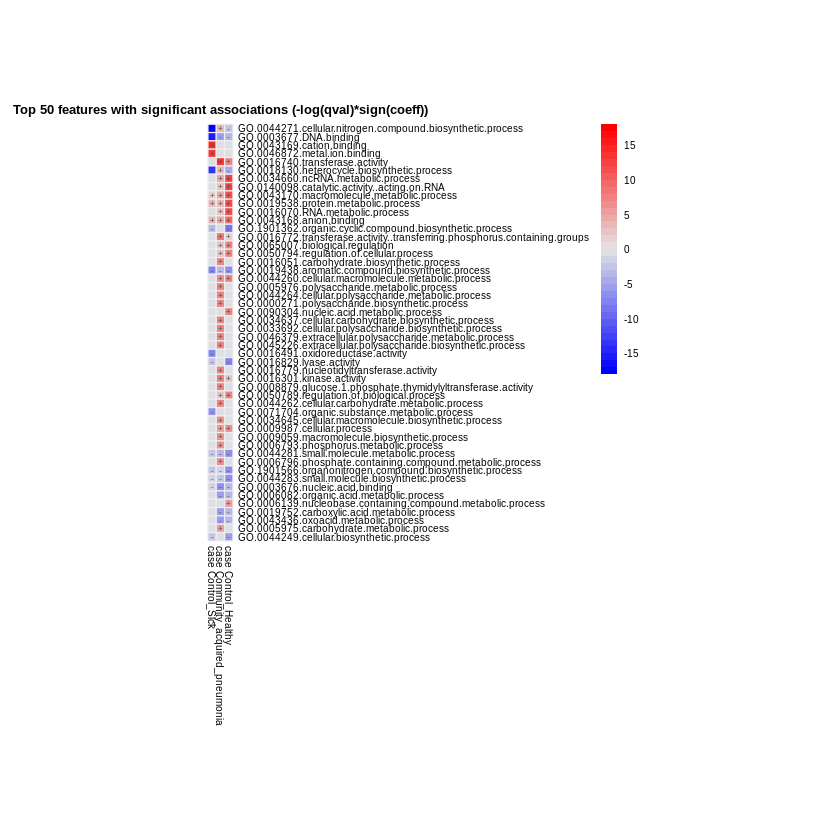

In [30]:
case<-Maaslin2(
  input_data = df_input_data2,
  input_metadata = df_input_metadata2,
  output="./case",
  min_abundance = 0.01,
  min_prevalence = 0.01,
  normalization = "NONE",
  transform = "NONE",
  analysis_method = "LM",
  max_significance = 0.25,
  #random_effects = c("sample_name","publication","collection_location","sequence_type"),
  random_effects = c("sample_name","publication"),
  fixed_effects = c("case"),
  correction="BH",
  standardize = TRUE,
  cores = 48,
  plot_heatmap = TRUE,
  plot_scatter = TRUE,
  heatmap_first_n = 100,
  reference=c("case,COVID19"))

In [31]:
outcome<-Maaslin2(
  input_data = df_input_data2,
  input_metadata = df_input_metadata2,
  output="./outcome",
  min_abundance = 0.001,
  min_prevalence = 0.001,
  normalization = "NONE",
  transform = "NONE",
  analysis_method = "LM",
  max_significance = 0.77,
  #random_effects = c("sample_name","publication","collection_location","sequence_type"),
  random_effects = c("sample_name","publication"),
  fixed_effects = c("outcome"),
  correction="BH",
  standardize = TRUE,
  cores = 48,
  plot_heatmap = TRUE,
  plot_scatter = TRUE,
  heatmap_first_n = 100,
  reference=c("outcome,Deceased"))

[1] "Warning: Deleting existing log file: ./outcome/maaslin2.log"
2020-11-24 13:47:31 INFO::Writing function arguments to log file
2020-11-24 13:47:31 INFO::Verifying options selected are valid
2020-11-24 13:47:31 INFO::Determining format of input files
2020-11-24 13:47:31 INFO::Input format is data samples as rows and metadata samples as rows
2020-11-24 13:47:31 INFO::Formula for random effects: expr ~ (1 | sample_name) + (1 | publication)
2020-11-24 13:47:31 INFO::Formula for fixed effects: expr ~  outcome
2020-11-24 13:47:31 INFO::Filter data based on min abundance and min prevalence
2020-11-24 13:47:31 INFO::Total samples in data: 141
2020-11-24 13:47:31 INFO::Min samples required with min abundance for a feature not to be filtered: 0.141000
2020-11-24 13:47:32 INFO::Total filtered features: 13051
2020-11-24 13:47:32 INFO::Filtered feature names from abundance and prevalence filtering: GO.0045212.obsolete.neurotransmitter.receptor.biosynthetic.process, GO.0001319.obsolete.inheritan

2020-11-24 13:48:37 INFO::Creating boxplot for categorical data, outcome vs GO.0022904.respiratory.electron.transport.chain
2020-11-24 13:48:37 INFO::Creating boxplot for categorical data, outcome vs GO.0043177.organic.acid.binding
2020-11-24 13:48:38 INFO::Creating boxplot for categorical data, outcome vs GO.0031406.carboxylic.acid.binding
2020-11-24 13:48:38 INFO::Creating boxplot for categorical data, outcome vs GO.0016763.transferase.activity..transferring.pentosyl.groups
2020-11-24 13:48:38 INFO::Creating boxplot for categorical data, outcome vs GO.0030554.adenyl.nucleotide.binding
2020-11-24 13:48:38 INFO::Creating boxplot for categorical data, outcome vs GO.0032559.adenyl.ribonucleotide.binding
2020-11-24 13:48:38 INFO::Creating boxplot for categorical data, outcome vs GO.0005524.ATP.binding
2020-11-24 13:48:38 INFO::Creating boxplot for categorical data, outcome vs GO.0033293.monocarboxylic.acid.binding
2020-11-24 13:48:39 INFO::Creating boxplot for categorical data, outcome vs

[1] "Warning: Deleting existing log file: ./age/maaslin2.log"
2020-11-24 13:48:41 INFO::Writing function arguments to log file
2020-11-24 13:48:41 INFO::Verifying options selected are valid
2020-11-24 13:48:41 INFO::Determining format of input files
2020-11-24 13:48:41 INFO::Input format is data samples as rows and metadata samples as rows
2020-11-24 13:48:42 INFO::Formula for random effects: expr ~ (1 | sample_name) + (1 | publication)
2020-11-24 13:48:42 INFO::Formula for fixed effects: expr ~  case + age
2020-11-24 13:48:42 INFO::Filter data based on min abundance and min prevalence
2020-11-24 13:48:42 INFO::Total samples in data: 141
2020-11-24 13:48:42 INFO::Min samples required with min abundance for a feature not to be filtered: 0.141000
2020-11-24 13:48:42 INFO::Total filtered features: 13051
2020-11-24 13:48:42 INFO::Filtered feature names from abundance and prevalence filtering: GO.0045212.obsolete.neurotransmitter.receptor.biosynthetic.process, GO.0001319.obsolete.inheritanc

2020-11-24 13:49:48 INFO::Writing association plots (one for each significant association) to output folder: ./age
2020-11-24 13:49:48 INFO::Plotting associations from most to least significant, grouped by metadata
2020-11-24 13:49:48 INFO::Plotting data for metadata number 1, case
2020-11-24 13:49:48 INFO::Creating boxplot for categorical data, case vs GO.0003676.nucleic.acid.binding
2020-11-24 13:49:48 INFO::Creating boxplot for categorical data, case vs GO.0044271.cellular.nitrogen.compound.biosynthetic.process
2020-11-24 13:49:48 INFO::Creating boxplot for categorical data, case vs GO.0051020.GTPase.binding
2020-11-24 13:49:48 INFO::Creating boxplot for categorical data, case vs GO.0005085.guanyl.nucleotide.exchange.factor.activity
2020-11-24 13:49:49 INFO::Creating boxplot for categorical data, case vs GO.0003677.DNA.binding
2020-11-24 13:49:49 INFO::Creating boxplot for categorical data, case vs GO.0018130.heterocycle.biosynthetic.process
2020-11-24 13:49:49 INFO::Creating boxplo

2020-11-24 13:49:57 INFO::Creating boxplot for categorical data, case vs GO.0008289.lipid.binding
2020-11-24 13:49:57 INFO::Creating boxplot for categorical data, case vs GO.0052692.raffinose.alpha.galactosidase.activity
2020-11-24 13:49:57 INFO::Creating boxplot for categorical data, case vs GO.0045333.cellular.respiration
2020-11-24 13:49:57 INFO::Creating boxplot for categorical data, case vs GO.0140110.transcription.regulator.activity
2020-11-24 13:49:58 INFO::Creating boxplot for categorical data, case vs GO.0016435.rRNA..guanine..methyltransferase.activity
2020-11-24 13:49:58 INFO::Creating boxplot for categorical data, case vs GO.0016072.rRNA.metabolic.process
2020-11-24 13:49:58 INFO::Creating boxplot for categorical data, case vs GO.0006364.rRNA.processing
2020-11-24 13:49:58 INFO::Creating boxplot for categorical data, case vs GO.0098772.molecular.function.regulator
2020-11-24 13:49:58 INFO::Creating boxplot for categorical data, case vs GO.0000451.rRNA.2.O.methylation
2020-1

2020-11-24 13:50:07 INFO::Creating boxplot for categorical data, case vs GO.0002161.aminoacyl.tRNA.editing.activity
2020-11-24 13:50:07 INFO::Creating boxplot for categorical data, case vs GO.0106074.aminoacyl.tRNA.metabolism.involved.in.translational.fidelity
2020-11-24 13:50:07 INFO::Creating boxplot for categorical data, case vs GO.0031167.rRNA.methylation
2020-11-24 13:50:07 INFO::Creating boxplot for categorical data, case vs GO.0004672.protein.kinase.activity
2020-11-24 13:50:07 INFO::Creating boxplot for categorical data, case vs GO.0000154.rRNA.modification
2020-11-24 13:50:07 INFO::Creating boxplot for categorical data, case vs GO.0097435.supramolecular.fiber.organization
2020-11-24 13:50:07 INFO::Creating boxplot for categorical data, case vs GO.0007015.actin.filament.organization
2020-11-24 13:50:08 INFO::Creating boxplot for categorical data, case vs GO.0001510.RNA.methylation
2020-11-24 13:50:08 INFO::Creating boxplot for categorical data, case vs GO.0015849.organic.acid.t

2020-11-24 13:50:16 INFO::Creating boxplot for categorical data, case vs GO.1902600.proton.transmembrane.transport
2020-11-24 13:50:16 INFO::Creating boxplot for categorical data, case vs GO.0007193.adenylate.cyclase.inhibiting.G.protein.coupled.receptor.signaling.pathway
2020-11-24 13:50:16 INFO::Creating boxplot for categorical data, case vs GO.0007196.adenylate.cyclase.inhibiting.G.protein.coupled.glutamate.receptor.signaling.pathway
2020-11-24 13:50:16 INFO::Creating boxplot for categorical data, case vs GO.0098988.G.protein.coupled.glutamate.receptor.activity
2020-11-24 13:50:17 INFO::Creating boxplot for categorical data, case vs GO.0001640.adenylate.cyclase.inhibiting.G.protein.coupled.glutamate.receptor.activity
2020-11-24 13:50:17 INFO::Creating boxplot for categorical data, case vs GO.0001642.group.III.metabotropic.glutamate.receptor.activity
2020-11-24 13:50:17 INFO::Creating boxplot for categorical data, case vs GO.0016311.dephosphorylation
2020-11-24 13:50:17 INFO::Creatin

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 29 rows containing missing values (geom_point).”


2020-11-24 13:50:26 INFO::Creating scatter plot for continuous data, age vs GO.0044036.cell.wall.macromolecule.metabolic.process


`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 28 rows containing missing values (geom_point).”


2020-11-24 13:50:26 INFO::Creating scatter plot for continuous data, age vs GO.0016667.oxidoreductase.activity..acting.on.a.sulfur.group.of.donors


`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 28 rows containing missing values (geom_point).”


2020-11-24 13:50:26 INFO::Creating scatter plot for continuous data, age vs GO.0016831.carboxy.lyase.activity


`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 29 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 29 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 28 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 28 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 29 rows containing missing values (geom_point).”


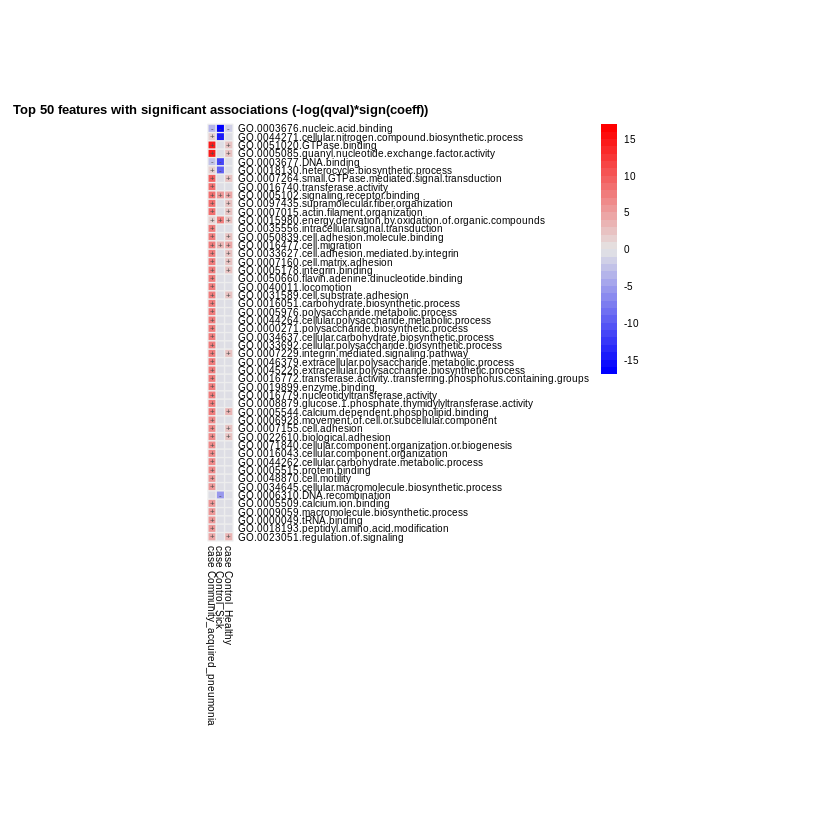

In [32]:
#I need to figure out how to change how to pivot wider the case colum for an age analysis
df_input_metadata2$age<-as.numeric(df_input_metadata2$age)

age<-Maaslin2(
  input_data = df_input_data2,
  input_metadata = df_input_metadata2,
  output="./age",
  min_abundance = 0.001,
  min_prevalence = 0.001,
  normalization = "NONE",
  transform = "NONE",
  analysis_method = "LM",
  max_significance = 0.25,
  #random_effects = c("sample_name","publication","collection_location","sequence_type"),
  random_effects = c("sample_name","publication"),
  fixed_effects = c("case","age"),
  correction="BH",
  standardize = TRUE,
  cores = 48,
  plot_heatmap = TRUE,
  plot_scatter = TRUE,
  heatmap_first_n = 100,
  reference=c("case,COVID19"))

## MaAsLin2 outcome analyisis (pruned_samples)

In [33]:
bac_pseq_outcome<-subset_samples(physeq = bac_pseq_no_neg,outcome!="NA")
#bac_pseq_outcome<-subset_samples(physeq = bac_pseq_no_neg, case=="COVID19")
bac_pseq_outcome
sample_info_tab<-sample_data(bac_pseq_outcome)
sample_info_tab_phy <- sample_data(sample_info_tab)
deseq_counts<-phyloseq_to_deseq2(physeq = bac_pseq_outcome,design = ~ 1) 
deseq_counts_vst <- estimateSizeFactors(deseq_counts, type = "poscounts")
vst_trans_count_tab <- assay(deseq_counts_vst)
vst_count_phy <- otu_table(vst_trans_count_tab, taxa_are_rows=T)
vst_tax_phy <- tax_table(bac_pseq_no_neg)
vst_physeq <- phyloseq(vst_count_phy, vst_tax_phy,sample_data(bac_pseq_outcome))
vst_physeq_comp<-microbiome::transform(x = vst_physeq,transform = "compositional")
df_input_data2<-data.frame(t(otu_table(vst_physeq_comp)))
df_input_metadata2<-data.frame(sample_data(vst_physeq_comp))

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 13844 taxa and 39 samples ]
sample_data() Sample Data:       [ 39 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 13844 taxa by 3 taxonomic ranks ]

converting counts to integer mode



#### ok thats interesting it looks like it just through everything else into NA regardless of case... I guess lets trying it again with only covid cases and also look at age

In [34]:
df_input_metadata2$age<-as.numeric(df_input_metadata2$age)
subset_outcome<-Maaslin2(
  input_data = df_input_data2,
  input_metadata = df_input_metadata2,
  output="./subset_outcome",
  min_abundance = 0.001,
  min_prevalence = 0.001,
  normalization = "NONE",
  transform = "NONE",
  analysis_method = "LM",
  max_significance = 0.25,
  random_effects = c("sample_name","publication"),
  fixed_effects = c("age","outcome"),
  correction="BH",
  standardize = TRUE,
  cores = 48,
  plot_heatmap = TRUE,
  plot_scatter = TRUE,
  heatmap_first_n = 100,
  reference="outcome,Deceased")

[1] "Warning: Deleting existing log file: ./subset_outcome/maaslin2.log"
2020-11-24 13:50:55 INFO::Writing function arguments to log file
2020-11-24 13:50:55 INFO::Verifying options selected are valid
2020-11-24 13:50:55 INFO::Determining format of input files
2020-11-24 13:50:55 INFO::Input format is data samples as rows and metadata samples as rows
2020-11-24 13:50:55 INFO::Formula for random effects: expr ~ (1 | sample_name) + (1 | publication)
2020-11-24 13:50:55 INFO::Formula for fixed effects: expr ~  age + outcome
2020-11-24 13:50:55 INFO::Filter data based on min abundance and min prevalence
2020-11-24 13:50:55 INFO::Total samples in data: 39
2020-11-24 13:50:55 INFO::Min samples required with min abundance for a feature not to be filtered: 0.039000
2020-11-24 13:50:55 INFO::Total filtered features: 13271
2020-11-24 13:50:55 INFO::Filtered feature names from abundance and prevalence filtering: GO.0045212.obsolete.neurotransmitter.receptor.biosynthetic.process, GO.0001319.obsole

2020-11-24 13:51:25 INFO::Creating boxplot for categorical data, outcome vs GO.0017076.purine.nucleotide.binding
2020-11-24 13:51:25 INFO::Creating boxplot for categorical data, outcome vs GO.0032555.purine.ribonucleotide.binding
2020-11-24 13:51:25 INFO::Creating boxplot for categorical data, outcome vs GO.0030554.adenyl.nucleotide.binding
2020-11-24 13:51:25 INFO::Creating boxplot for categorical data, outcome vs GO.0032559.adenyl.ribonucleotide.binding
2020-11-24 13:51:26 INFO::Creating boxplot for categorical data, outcome vs GO.0005524.ATP.binding


## DMM modeling using the MaAslin2 derived terms

Ok, lets import the MaAsLin2 derived significant terms

In [35]:
res<-case$results%>%filter(pval<=0.05)

## DMM Preprocessing /filtering

Ok lets filter out the GO_tag mataches from our phyloseq object

In [36]:
Terms<-gsub("GO.","GO:",res$feature)
Terms<-gsub("[.]"," ",Terms)
Terms<-sub(" ","-",Terms)
Terms<-as_tibble(Terms)
Terms<-separate(data = Terms,col = value,sep = "-",into =  c("Term", "name"))

In [37]:
bac_pseq_no_neg<-subset_samples(bac_pseq, sample_type!="neg_control")
bac_pseq_no_neg<-subset_samples(bac_pseq_no_neg, sample_type!="Unknown")
bac_pseq_no_neg #[ 13846 taxa and 141 samples ]:

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 13844 taxa and 141 samples ]
sample_data() Sample Data:       [ 141 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 13844 taxa by 3 taxonomic ranks ]

In [38]:
bac_pseq_prune <- prune_taxa(taxa = Terms$Term,x =  bac_pseq_no_neg)
bac_pseq_prune #[85 taxa and 141 samples ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 85 taxa and 141 samples ]
sample_data() Sample Data:       [ 141 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 85 taxa by 3 taxonomic ranks ]

Ok lets fix our names again

In [39]:
tax<-data.frame(tax_table(bac_pseq_prune))
names<-paste(rownames(tax),tax$name,sep="-")
taxa_names(bac_pseq_prune)<-names

#### DMM modeling time

convert counts to a matrix

In [40]:
dat <- abundances(bac_pseq_prune)
count <- as.matrix(t(dat))

Fit the dmm model

In [41]:
fit <- mclapply(1:8, dmn, count = count, verbose=TRUE)

Check the model fit with different number of mixture componenets using standard information criteria

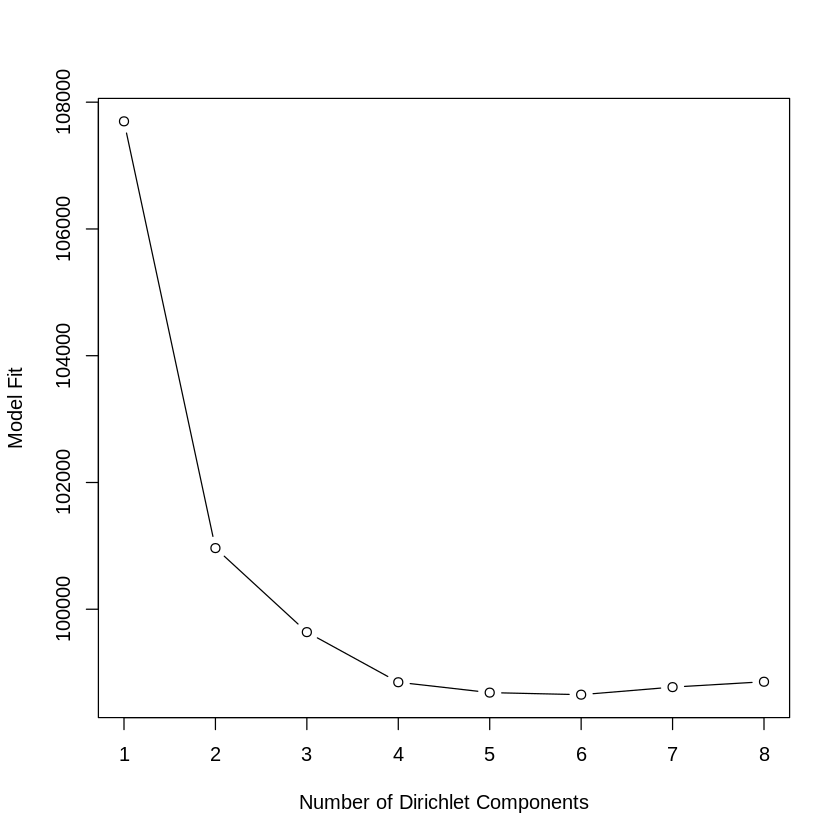

In [42]:
lplc <- sapply(fit, laplace) # AIC / BIC / Laplace
aic  <- sapply(fit, AIC) # AIC / BIC / Laplace
bic  <- sapply(fit, BIC) # AIC / BIC / Laplace
plot(lplc, type="b", xlab="Number of Dirichlet Components", ylab="Model Fit")

In [43]:
#identify the number of clusters that best fits the model

In [44]:
best <- fit[[which.min(lplc)]]
best <-fit[[4]]
best

class: DMN 
k: 4 
samples x taxa: 141 x 85 
Laplace: 98848.2 BIC: 98692.23 AIC: 98186.52 

In [45]:
#save.image(file = "go_terms_dmm.rdata")

#make a heatmap visualization of the cluster

log 2 Heatmap

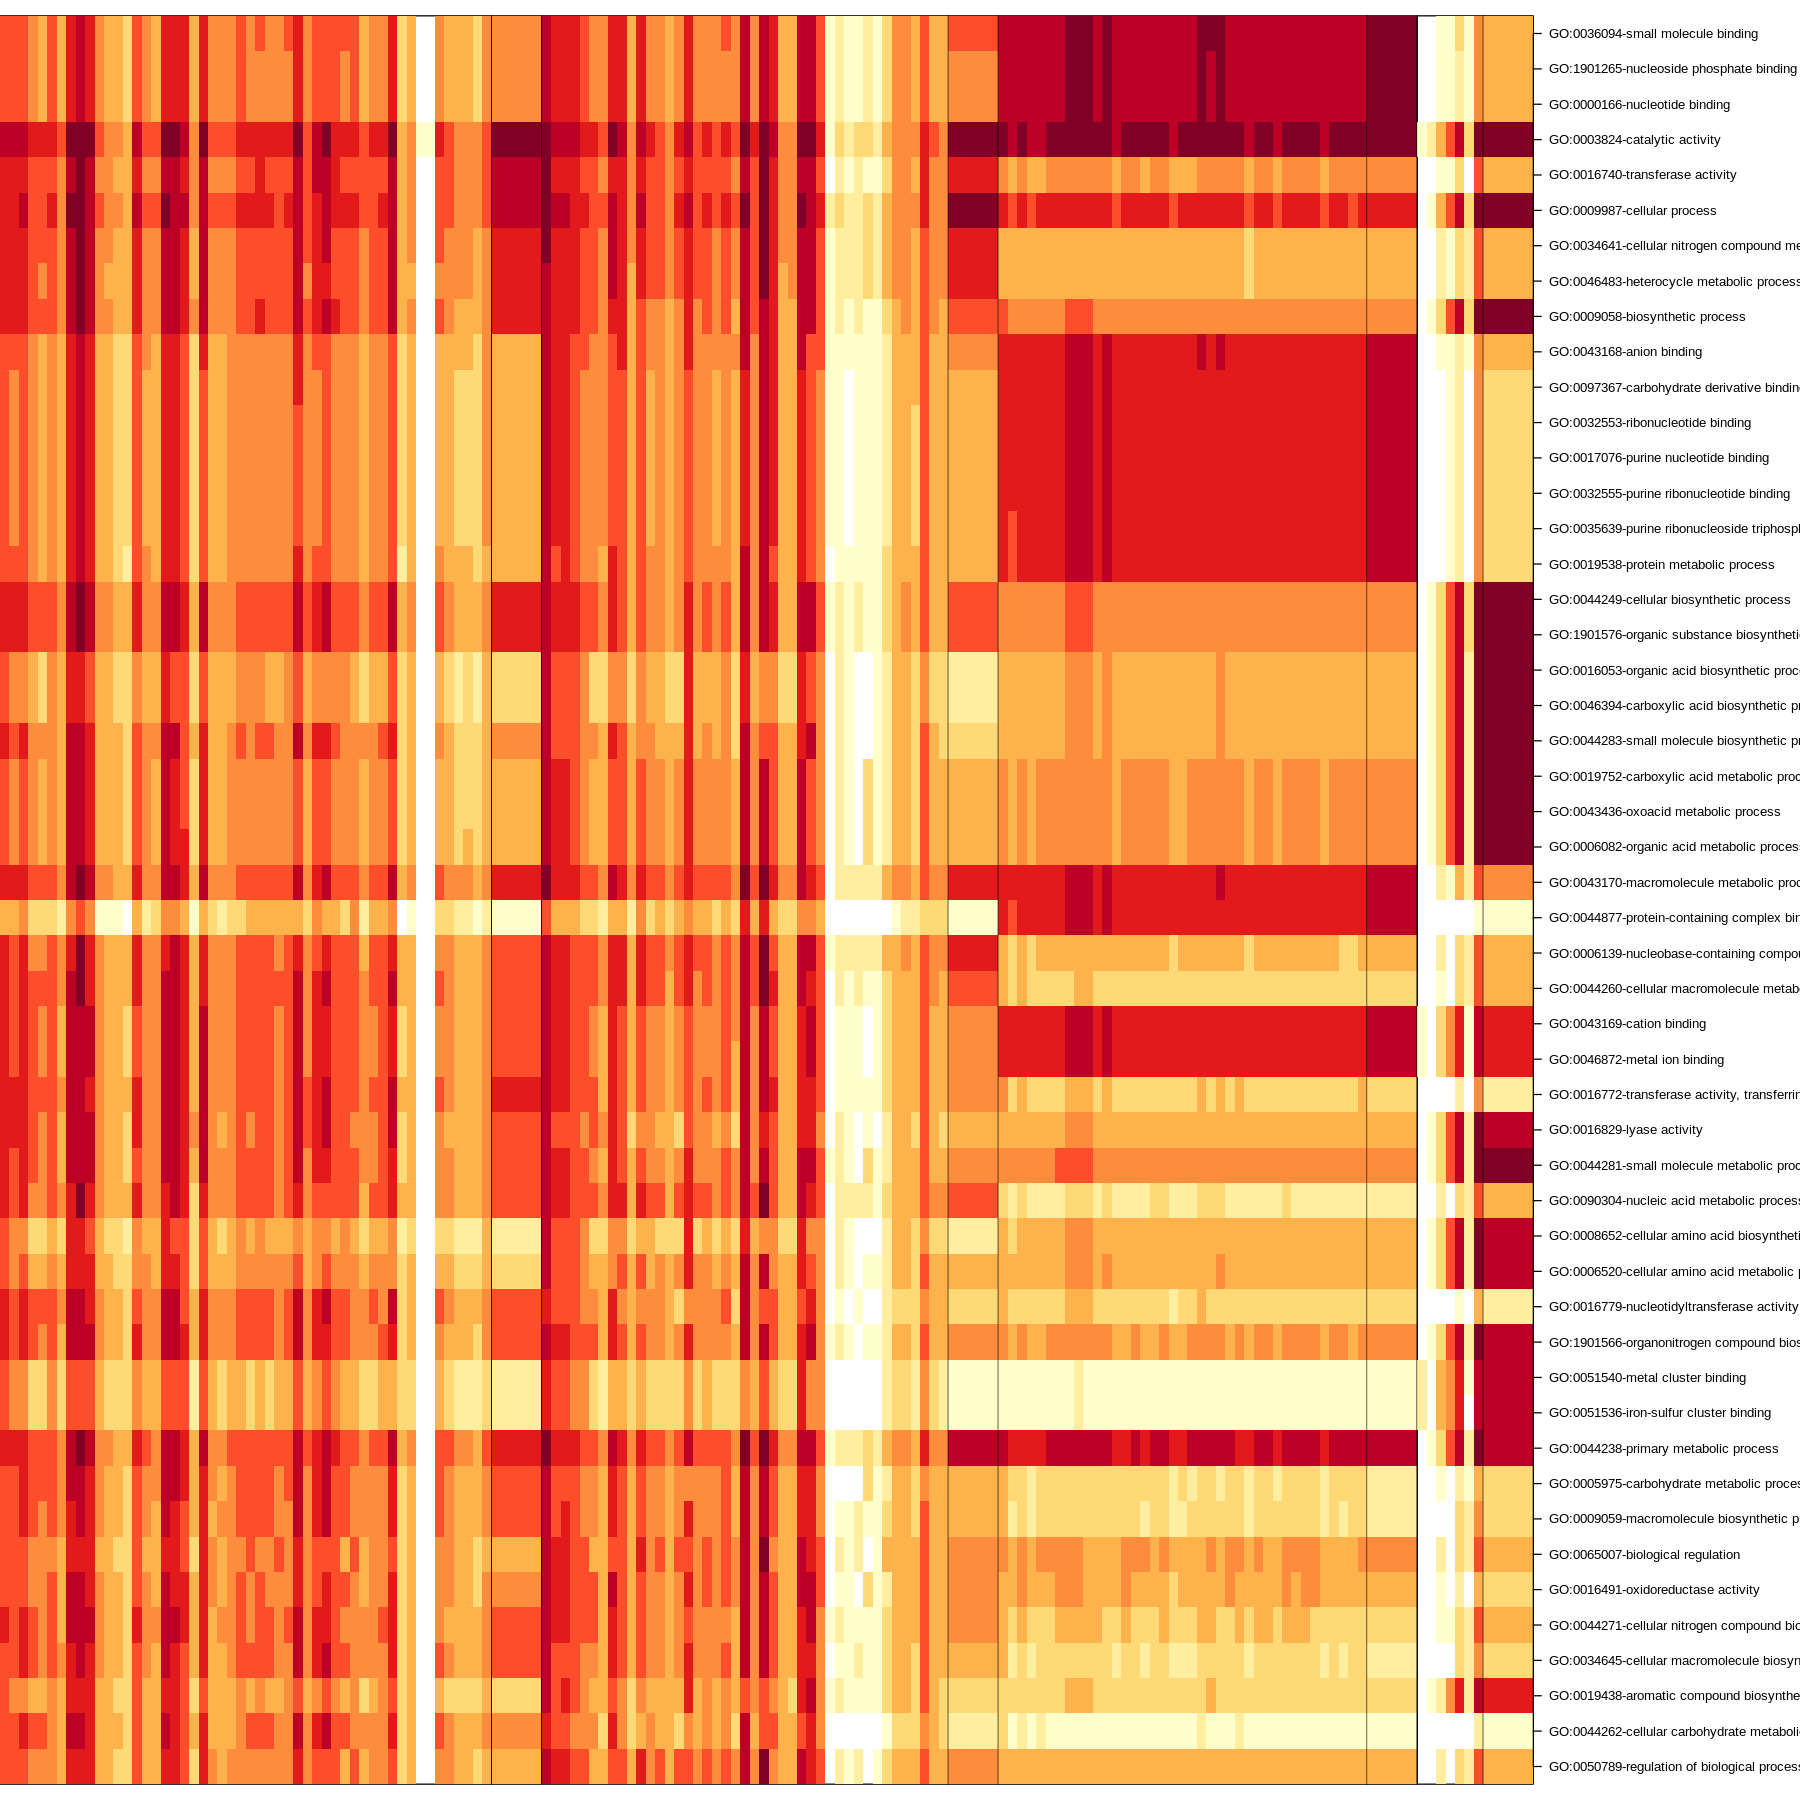

In [46]:
options(repr.plot.width=15, repr.plot.height=15)
heatmapdmn(count, fit[[1]], best,ntaxa = 50,
           transform =log2, lblwidth = 0.2 * nrow(count))

square root version

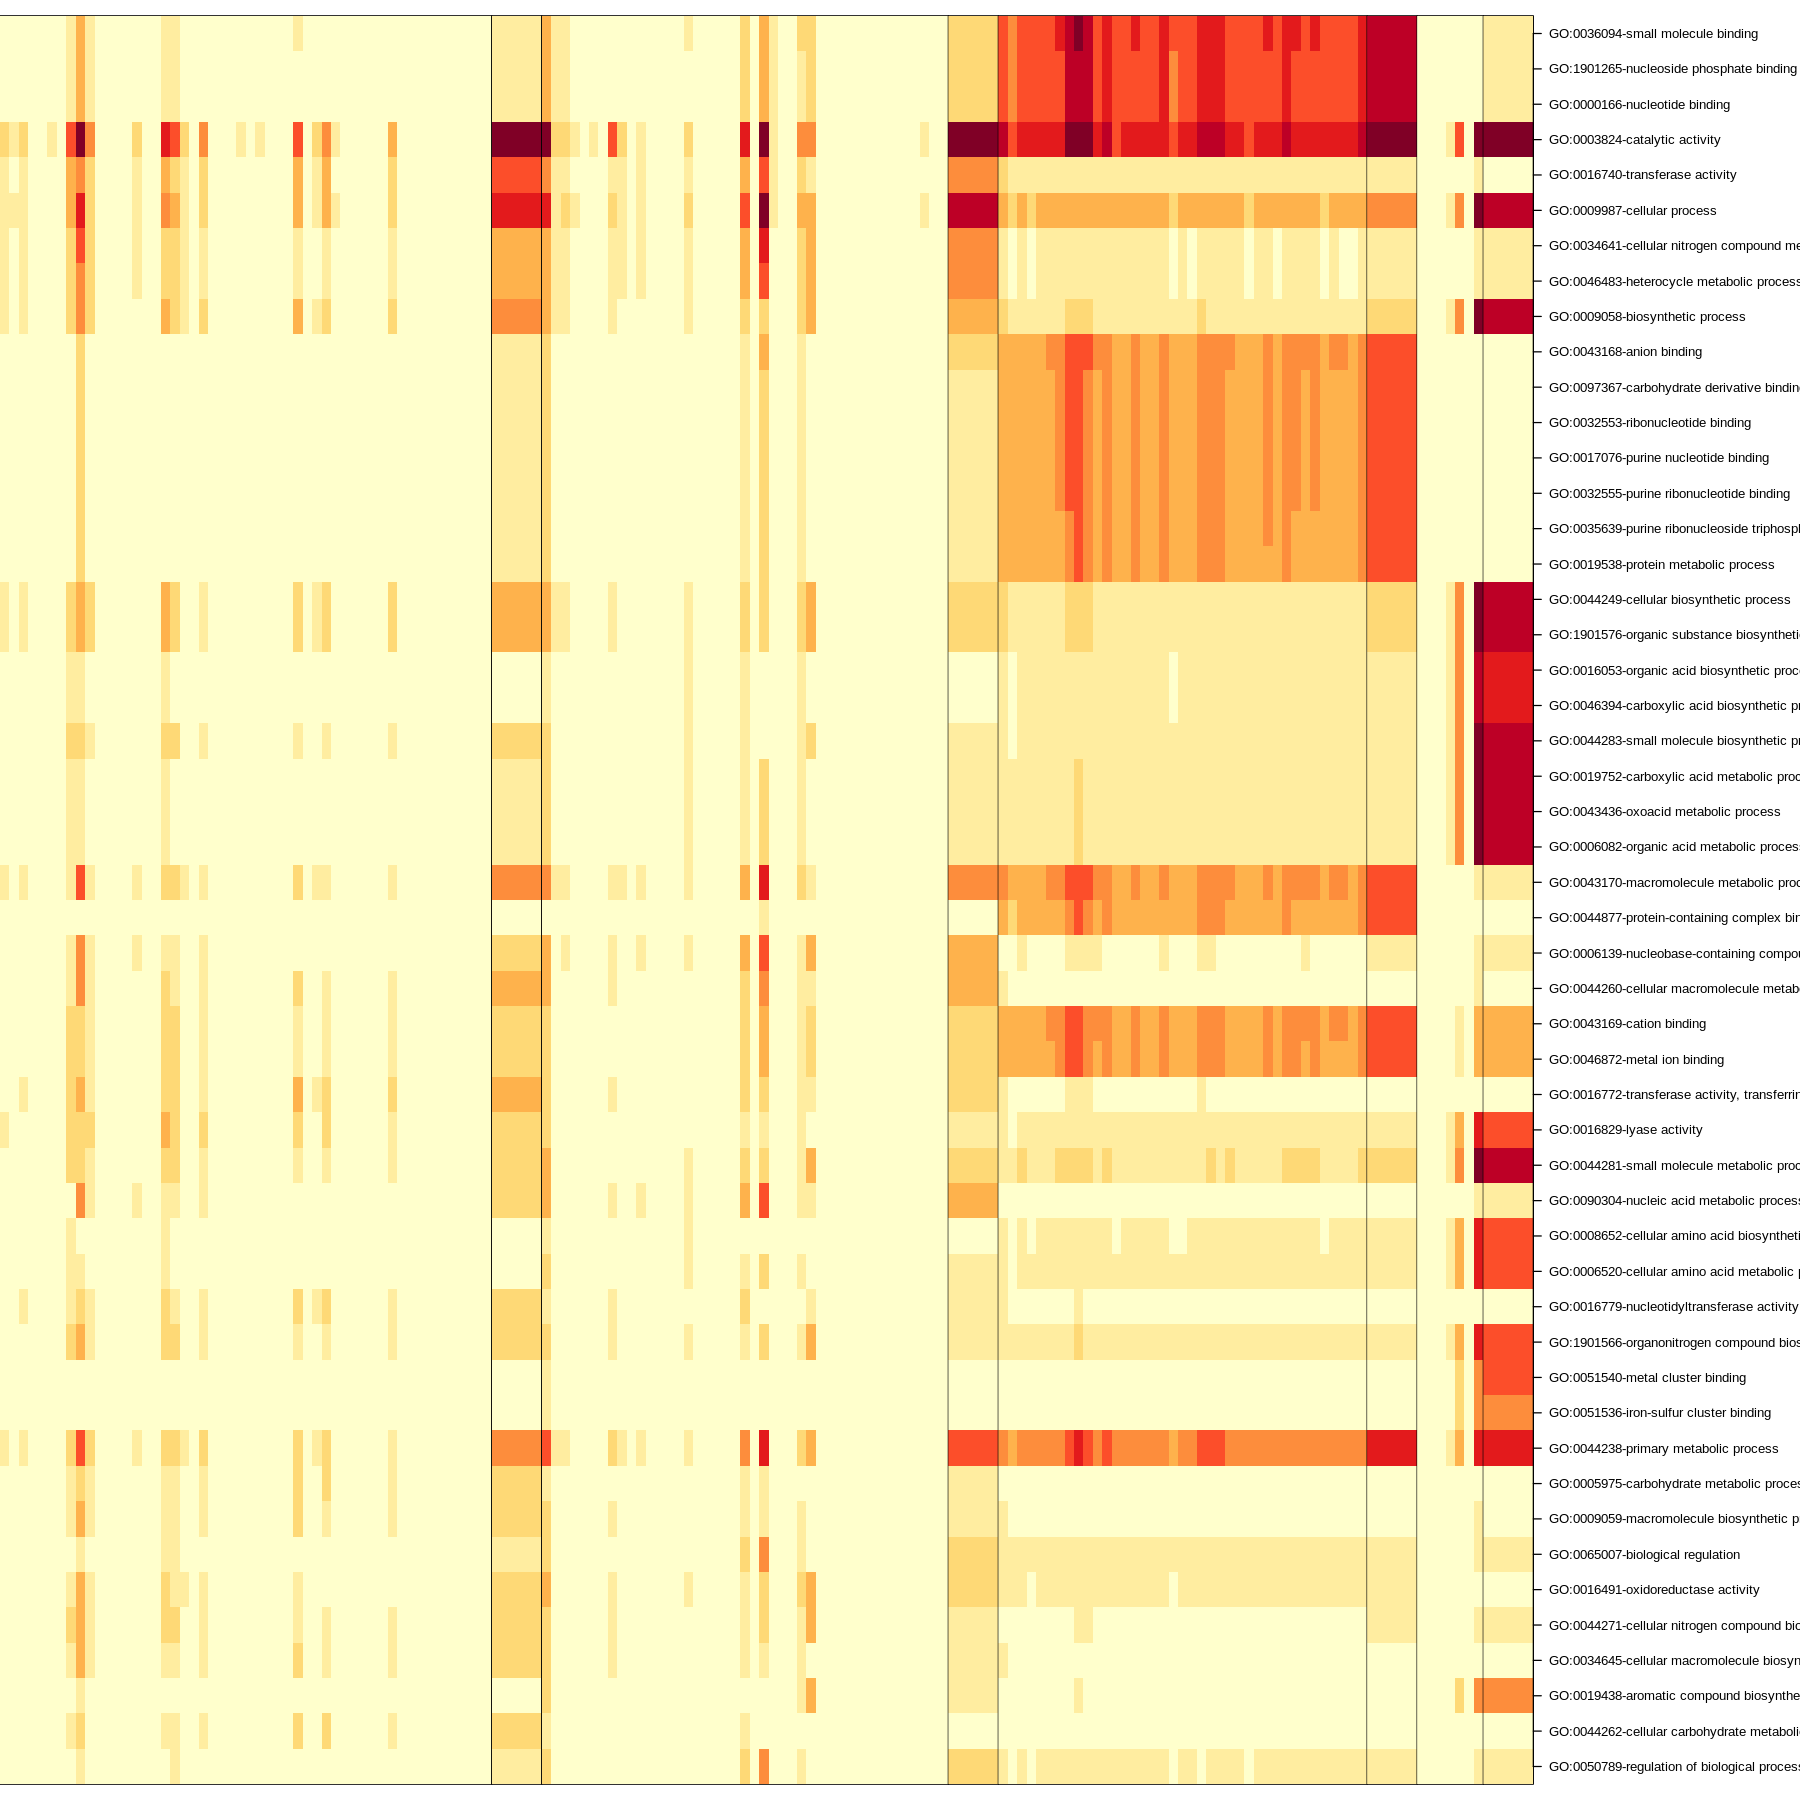

In [47]:
options(repr.plot.width=15, repr.plot.height=15)
heatmapdmn(count, fit[[1]], best,ntaxa = 50,
           transform =sqrt, lblwidth = 0.2 * nrow(count))

print out the theta values

In [48]:
mixturewt(best)

pi         theta    
1 0.36108385  703.1264
2 0.31031729  327.4110
3 0.27880649 9131.3508
4 0.04979237  293.0860

save the datasheet that show which GO terms contributed to each dmm group

In [49]:
write.table(fitted(best),"GO_TERMS_DMM_contributions.tsv", sep="\t")

save a datasheet that identifies which sample belongs to which dmm group

In [50]:
ass <- apply(mixture(best), 1, which.max)
write.table(ass,"GO_TERMS_DMM_groups.tsv",sep="")

In [51]:
#add the dmm group to the metadata
sample_data(bac_pseq_prune)$dmn<-ass
bac_pseq_prune_comp<-microbiome::transform(bac_pseq_prune,"compositional")
#melt the phyloseq object into tidy form
tmp<-psmelt(bac_pseq_prune_comp)
tmp<-as_tibble(tmp)

Warning message:
“Using `bins = 30` by default. Pick better value with the argument `bins`.”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 790 rows containing non-finite values (stat_bin).”


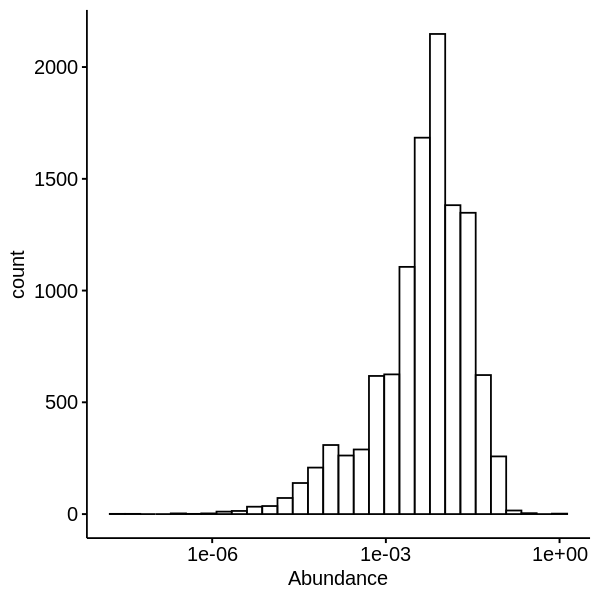

In [52]:
options(repr.plot.width=5, repr.plot.height=5)
gghistogram(tmp,x = "Abundance",y = "..count..")+scale_x_log10() #move each dmm group into a colum of its own

In [53]:
#tmp$log2Abundance<-log2(tmp$Abundance)

In [54]:
#subset the dataset to only include the case, Go_term, count, and dmm group.
#obtain the avergage count for each Go term
#order the go terms from hight to lowest count

I added these filtering commands to pull out the counts with less than 1% relabund or greater tahn 22% (ie:molecular function)

In [55]:
d2<-tmp %>%
  select(case,OTU,Abundance, dmn)%>%
  group_by(OTU,case, dmn) %>%
  summarise(avg = mean(Abundance)) %>%
  arrange(desc(avg))

`summarise()` regrouping output by 'OTU', 'case' (override with `.groups` argument)



In [56]:
#d2$avg<-sqrt(d2$avg)

In [57]:
#get the total count of the go terms and oder from greates to lowest


In [58]:
d3<-tidyr::spread(d2,dmn,avg)
d3$tot<-rowSums(d3[3:6], na.rm = T)
d3<-d3%>%arrange(desc(tot))
d3$tot<-NULL
head(d3)

OTU                                            case                        
1 GO:0003824-catalytic activity                  COVID19                     
2 GO:0003824-catalytic activity                  Control_Healthy             
3 GO:0003824-catalytic activity                  Community_acquired_pneumonia
4 GO:0009987-cellular process                    Control_Healthy             
5 GO:0009987-cellular process                    COVID19                     
6 GO:0071704-organic substance metabolic process Control_Healthy             
  1          2          3          4         
1 0.19709584 0.11377099         NA 0.07816223
2 0.10651611 0.09753441 0.08690861         NA
3 0.10982318 0.09529182         NA         NA
4 0.06406395 0.07532293 0.02466242         NA
5 0.05546210 0.06485203         NA 0.04088421
6 0.04601136 0.05094096 0.04741581         NA

In [59]:
d3<-d3%>%gather(data = d3,avg,3:6)
colnames(d3)<-c("name","case", "dmn","avg")

make the balloon plot

In [60]:
d4<-d3%>%filter(avg>0.01)%>%arrange(name,case,dmn)
d4<-d4[1:108,]
d4

name                                                                      
1   GO:0000166-nucleotide binding                                             
2   GO:0000166-nucleotide binding                                             
3   GO:0000166-nucleotide binding                                             
4   GO:0000166-nucleotide binding                                             
5   GO:0000166-nucleotide binding                                             
6   GO:0003676-nucleic acid binding                                           
7   GO:0003676-nucleic acid binding                                           
8   GO:0003676-nucleic acid binding                                           
9   GO:0003676-nucleic acid binding                                           
10  GO:0003824-catalytic activity                                             
11  GO:0003824-catalytic activity                                             
12  GO:0003824-catalytic activity                                             
13  GO:0003824-catalytic activity                                             
14  GO:0003824-catalytic activity                                             
15  GO:0003824-catalytic activity                                             
16  GO:0003824-catalytic activity                                             
17  GO:0003824-catalytic activity                                             
18  GO:0003824-catalytic activity                                             
19  GO:0005975-carbohydrate metabolic process                                 
20  GO:0005975-carbohydrate metabolic process                                 
21  GO:0006082-organic acid metabolic process                                 
22  GO:0006082-organic acid metabolic process                                 
23  GO:0006139-nucleobase-containing compound metabolic process               
24  GO:0006139-nucleobase-containing compound metabolic process               
25  GO:0006139-nucleobase-containing compound metabolic process               
26  GO:0006139-nucleobase-containing compound metabolic process               
27  GO:0006139-nucleobase-containing compound metabolic process               
28  GO:0006139-nucleobase-containing compound metabolic process               
29  GO:0006520-cellular amino acid metabolic process                          
30  GO:0006793-phosphorus metabolic process                                   
⋮   ⋮                                                                         
79  GO:0016772-transferase activity, transferring phosphorus-containing groups
80  GO:0016772-transferase activity, transferring phosphorus-containing groups
81  GO:0016772-transferase activity, transferring phosphorus-containing groups
82  GO:0016772-transferase activity, transferring phosphorus-containing groups
83  GO:0016779-nucleotidyltransferase activity                                
84  GO:0016779-nucleotidyltransferase activity                                
85  GO:0016779-nucleotidyltransferase activity                                
86  GO:0016829-lyase activity                                                 
87  GO:0016829-lyase activity                                                 
88  GO:0016829-lyase activity                                                 
89  GO:0016829-lyase activity                                                 
90  GO:0016874-ligase activity                                                
91  GO:0017076-purine nucleotide binding                                      
92  GO:0017076-purine nucleotide binding                                      
93  GO:0018130-heterocycle biosynthetic process                               
94  GO:0018130-heterocycle biosynthetic process                               
95  GO:0019438-aromatic compound biosynthetic process                         
96  GO:0019538-protein metabolic process                                      
97  GO:0019538-protein metabolic process              

In [61]:
my_pal<-viridis(n = 256, alpha = 1, begin = 0, end = 1, direction = 1)

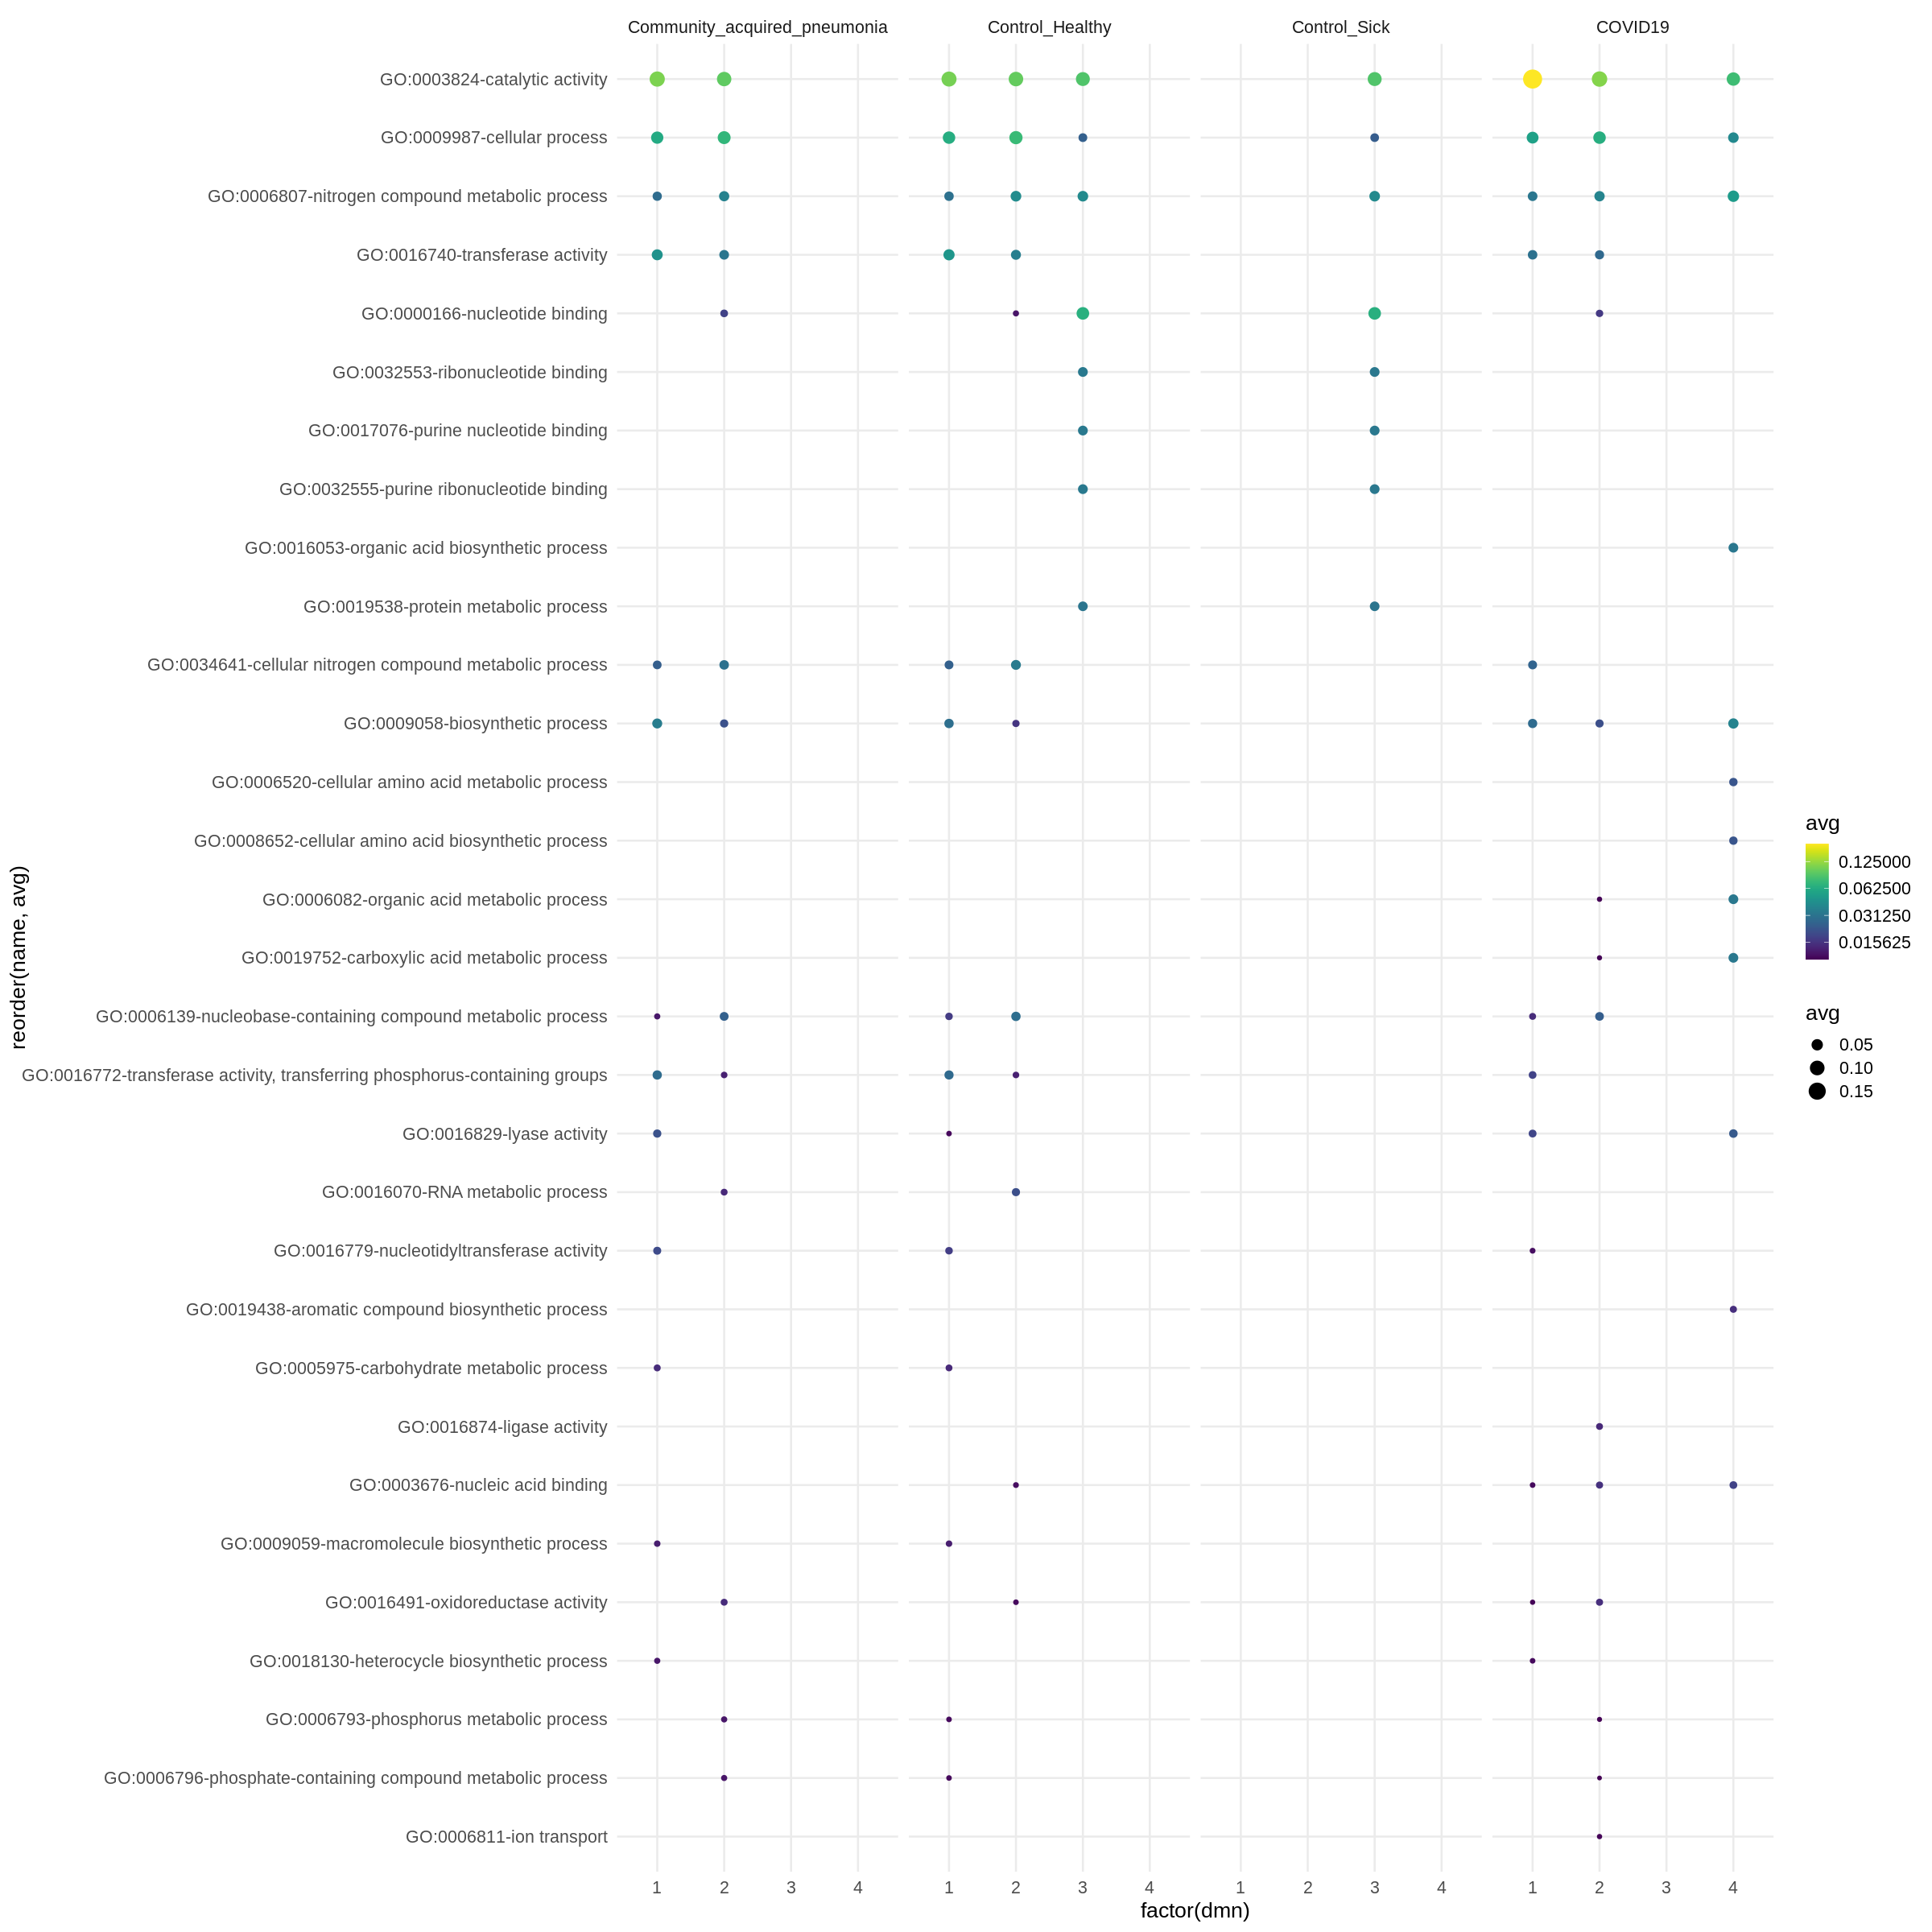

In [62]:
options(repr.plot.width=20, repr.plot.height=20)
a<-ggplot(data = d4,mapping = aes(x = factor(dmn),y =reorder(name,avg),size=avg,color=avg))+
geom_point()+
#theme(text=element_text(size=20))+
scale_colour_gradientn(colours = my_pal,trans="log2")+
facet_grid(facets = ~ case)+
theme_minimal(base_size = 16)

a

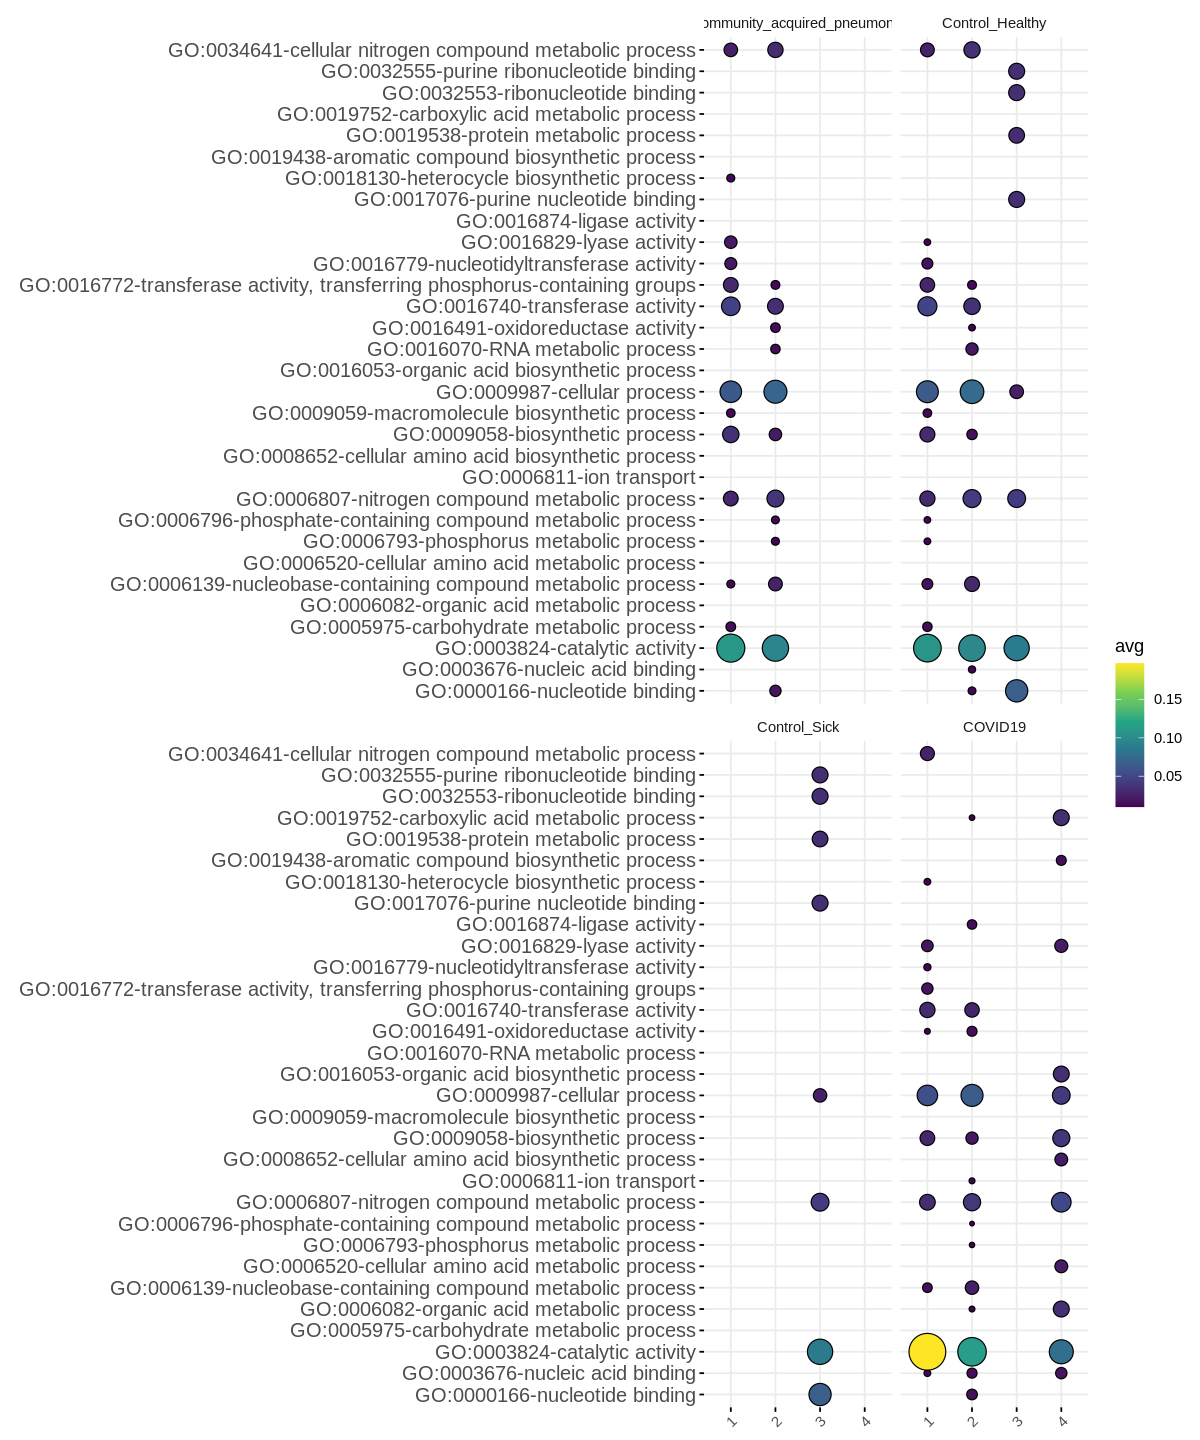

In [119]:
options(repr.plot.width=10, repr.plot.height=12)    
ggballoonplot(d4, y ="name",x = "dmn", size = "avg", facet.by = "case",fill = "avg",ggtheme = theme_minimal())+
     guides(size = FALSE)+
    font("y.text", size = 12)+scale_fill_viridis_c()

In [64]:
save.image("GO_TERM_Maaslin2_23_NOV_2020.rda")
#load.Rdata("GO_TERM_Maaslin2_19_NOV_2020.rda")

## DATA VISUALIZATION TIME and outcome comparison time

In [65]:
sam<-as_tibble(sample_data(bac_pseq_prune))
tbl<-tally(x = case~dmn,sam, format = "count")

Warning message in class(x) <- c(setdiff(subclass, tibble_class), tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”


In [66]:
case<-as.vector(tally(~case,sam))
case
dmn<-as.vector(tally(~dmn,sam))
dmn
cor.test(case,dmn)
cor(case,dmn)
cov(case,dmn)

[1] 25 32 36 48

[1] 52 43 39  7


	Pearson's product-moment correlation

data:  x and y
t = -6.5926, df = 2, p-value = 0.02224
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.9995538 -0.2764827
sample estimates:
       cor 
-0.9777565 


[1] -0.9777565

[1] -184.75

ok lets do a binomial test to see if we can use this

In [67]:
out_tbl<-tally(x = case~dmn,sam)
result2 <-chisq.test(table(out_tbl))
out_tbl
result2
chisq(result2)

Warning message in chisq.test(table(out_tbl)):
“Chi-squared approximation may be incorrect”


                              dmn
case                            1  2  3  4
  Community_acquired_pneumonia 16  9  0  0
  Control_Healthy              15 14  3  0
  Control_Sick                  0  0 36  0
  COVID19                      21 20  0  7


	Chi-squared test for given probabilities

data:  table(out_tbl)
X-squared = 20.25, df = 9, p-value = 0.01643


X.squared 
    20.25

YAAAASSSSSS CASE ~OUTCOME Chi-squared TEST P=0.0517
LESGOOOO

## HEATMAP TIME

In [68]:
###########################################
###Dont forget to save you shit HERE#######
###########################################
#save.image(file = "bac_go_terms_dmm.rdata")
#

In [69]:
count<-abundances(bac_pseq_prune)
select <- order(rowMeans(count),decreasing=TRUE)
select3<-order(rowSdDiffs(count),decreasing=T)
select2<-log1p((count)[select3,])
tmp<-rownames(select2)
dim(select2)

[1]  85 141

In [70]:
#select2$mol<-tmp
select_tibb<-as_tibble(select2)
rownames(select_tibb)<-rownames(select2)
write.table(select2,file = "GO_Terms_results")

Warning message:
“Setting row names on a tibble is deprecated.”


In [71]:
#library(matrixTests)
#library(genefilter)
#select3<-as_tibble(select2)%>%summarise(std=rowFtests(select2))%>% arrange(desc(std))
#select2$mol<-tmp
select2<-as_tibble(select2)
#select2$mean<-rowMeans(select2)

In [72]:
rownames(select2)<-tmp
rownames(select2)
sam<-data.frame(sample_data(bac_pseq_prune))
df<-as.data.frame(sample_data(bac_pseq_prune))
df<-as_tibble(df)
df<-df%>%select(dmn, publication, sample_type,case)#,dmn,body_site)
df<-as.data.frame(df)

Warning message:
“Setting row names on a tibble is deprecated.”


[1] "GO:0003824-catalytic activity"                                             
 [2] "GO:0009987-cellular process"                                               
 [3] "GO:0071704-organic substance metabolic process"                            
 [4] "GO:0044238-primary metabolic process"                                      
 [5] "GO:0006807-nitrogen compound metabolic process"                            
 [6] "GO:0043170-macromolecule metabolic process"                                
 [7] "GO:0034641-cellular nitrogen compound metabolic process"                   
 [8] "GO:0016740-transferase activity"                                           
 [9] "GO:0046483-heterocycle metabolic process"                                  
[10] "GO:0006139-nucleobase-containing compound metabolic process"               
[11] "GO:0090304-nucleic acid metabolic process"                                 
[12] "GO:0009058-biosynthetic process"                                           
[13] "GO:0044260-cellular macromolecule metabolic process"                       
[14] "GO:0016070-RNA metabolic process"                                          
[15] "GO:1901576-organic substance biosynthetic process"                         
[16] "GO:0044249-cellular biosynthetic process"                                  
[17] "GO:0034660-ncRNA metabolic process"                                        
[18] "GO:0016772-transferase activity, transferring phosphorus-containing groups"
[19] "GO:0065007-biological regulation"                                          
[20] "GO:0003676-nucleic acid binding"                                           
[21] "GO:0036094-small molecule binding"                                         
[22] "GO:0140098-catalytic activity, acting on RNA"                              
[23] "GO:0044281-small molecule metabolic process"                               
[24] "GO:1901265-nucleoside phosphate binding"                                   
[25] "GO:0000166-nucleotide binding"                                             
[26] "GO:0016829-lyase activity"                                                 
[27] "GO:0016491-oxidoreductase activity"                                        
[28] "GO:0050789-regulation of biological process"                               
[29] "GO:0050794-regulation of cellular process"                                 
[30] "GO:1901566-organonitrogen compound biosynthetic process"                   
[31] "GO:0044271-cellular nitrogen compound biosynthetic process"                
[32] "GO:0004518-nuclease activity"                                              
[33] "GO:0016779-nucleotidyltransferase activity"                                
[34] "GO:0043169-cation binding"                                                 
[35] "GO:0046872-metal ion binding"                                              
[36] "GO:0009059-macromolecule biosynthetic process"                             
[37] "GO:0016874-ligase activity"                                                
[38] "GO:0034645-cellular macromolecule biosynthetic process"                    
[39] "GO:0006793-phosphorus metabolic process"                                   
[40] "GO:1901362-organic cyclic compound biosynthetic process"                   
[41] "GO:0006796-phosphate-containing compound metabolic process"                
[42] "GO:0018130-heterocycle biosynthetic process"                               
[43] "GO:0043168-anion binding"                                                  
[44] "GO:0044283-small molecule biosynthetic process"                            
[45] "GO:0005975-carbohydrate metabolic process"                                 
[46] "GO:0019538-protein metabolic process"                                      
[47] "GO:0003677-DNA binding"                                                    
[48] "GO:0006082-organic acid metabolic process"                                 
[49] "GO:0043436-oxoacid metabolic process"                      

Warning message in class(x) <- c(setdiff(subclass, tibble_class), tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”


In [73]:
#select2<-sqrt((count)[select,])
dim(select2)
colnames(select2) <- colnames(otu_table(bac_pseq_prune))
length(rownames(select2))
length(row.names(df))
row.names(df) <- colnames(select2)

[1]  85 141

[1] 85

[1] 141

In [74]:
library(ggsci)

In [75]:
mypal <- pal_aaas("default", alpha = 1)(10)
mypal
library("scales")
library(RColorBrewer)
library(viridis)
library(pheatmap)
df_row<-as.data.frame(fitted(best))
#colnames(df_row)<-c("1","2","3","4","5","6")
df<-data.frame(df)
colnames(df)<-c("dmm_cluster", "Publication","Sample_Type","Case")

[1] "#3B4992FF" "#EE0000FF" "#008B45FF" "#631879FF" "#008280FF" "#BB0021FF"
 [7] "#5F559BFF" "#A20056FF" "#808180FF" "#1B1919FF"


Attaching package: ‘scales’


The following object is masked from ‘package:mosaic’:

    rescale


The following object is masked from ‘package:viridis’:

    viridis_pal


The following object is masked from ‘package:microbiome’:

    alpha


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




In [76]:
# Specify colors

In [77]:
ann_colors = list(
  dmm_cluster=c("1"="#3B4992FF","2"="#EE0000FF","3"="#008B45FF","4"="#631879FF"),#,"5"="#008280FF"),
  Publication=c("Xiong"="#008280FF", "Shen"="#631879FF","Michalovich"="#BB0021FF","Chen"="#3B4992FF","Wu"="#EE0000FF","Zhou"="orange","Ren"="#111111"),
  Sample_Type =c("COVID_19"="firebrick",
                 "Healthy"="forestgreen",
                 "Community_acquired_pneumonia"="darkorange1",
                 "Obese_Asthma"="goldenrod3",
                 "Obese_Smoker"="goldenrod4", 
                 "Obese"="goldenrod1",
                 "Asthma"= "dodgerblue2", 
                 "Asthma_Smoker"="dodgerblue4",
                 "Asthma_Ex_smoker"="dodgerblue3",
                 "Smoker"="gray27",
                 "Obese_Asthma_Smoker"="black"),
  Case=c("COVID19"="firebrick","Community_acquired_pneumonia"="darkorange1", "Control_Healthy"="forestgreen","Control_Sick"="dodgerblue4"))

In [96]:
select3<-select2%>%filter(rowMeans(select2)>8)
dim(select2)
dim(select3)

[1]  85 141

[1]  45 141

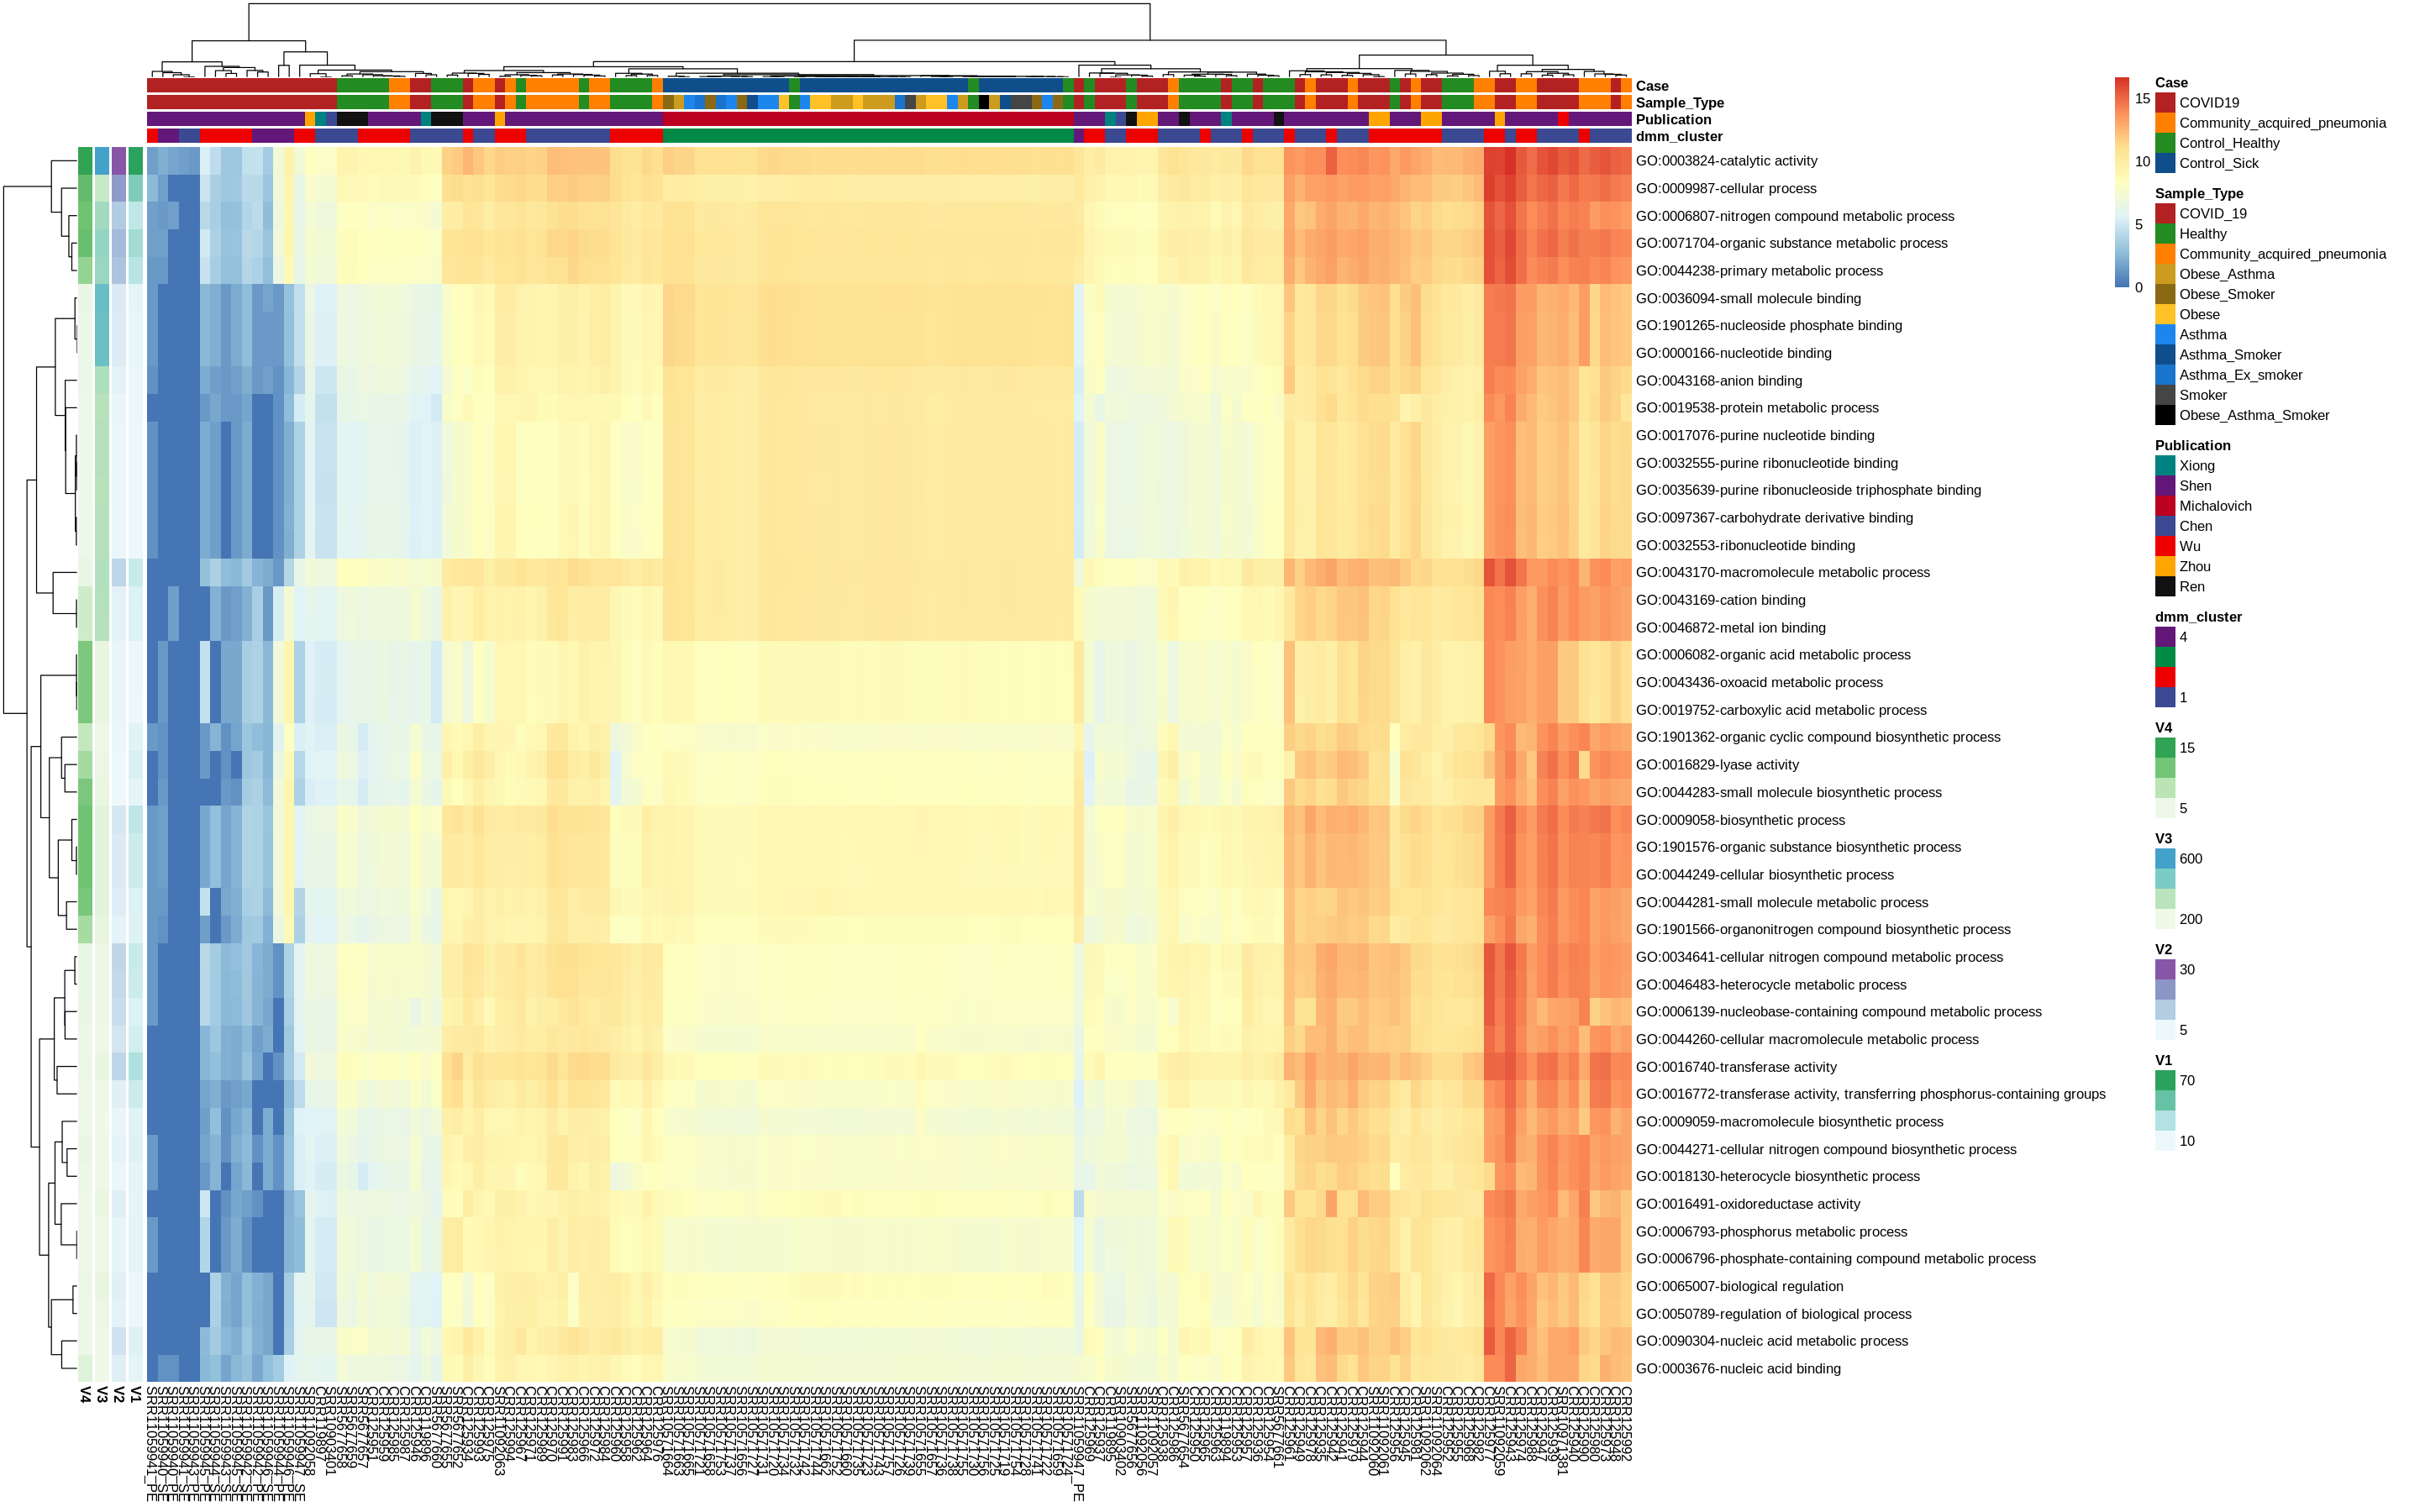

In [97]:
options(repr.plot.width=24, repr.plot.height=15)
xx <- pheatmap(mat = select3,
               color = colorRampPalette(rev(brewer.pal(n = 7, name ="RdYlBu")))(1000),
               annotation_col=df,
               annotation_colors = ann_colors,
               clustering_distance_rows = "euclidean",
               clustering_distance_cols = "euclidean",
              annotation_row = df_row)

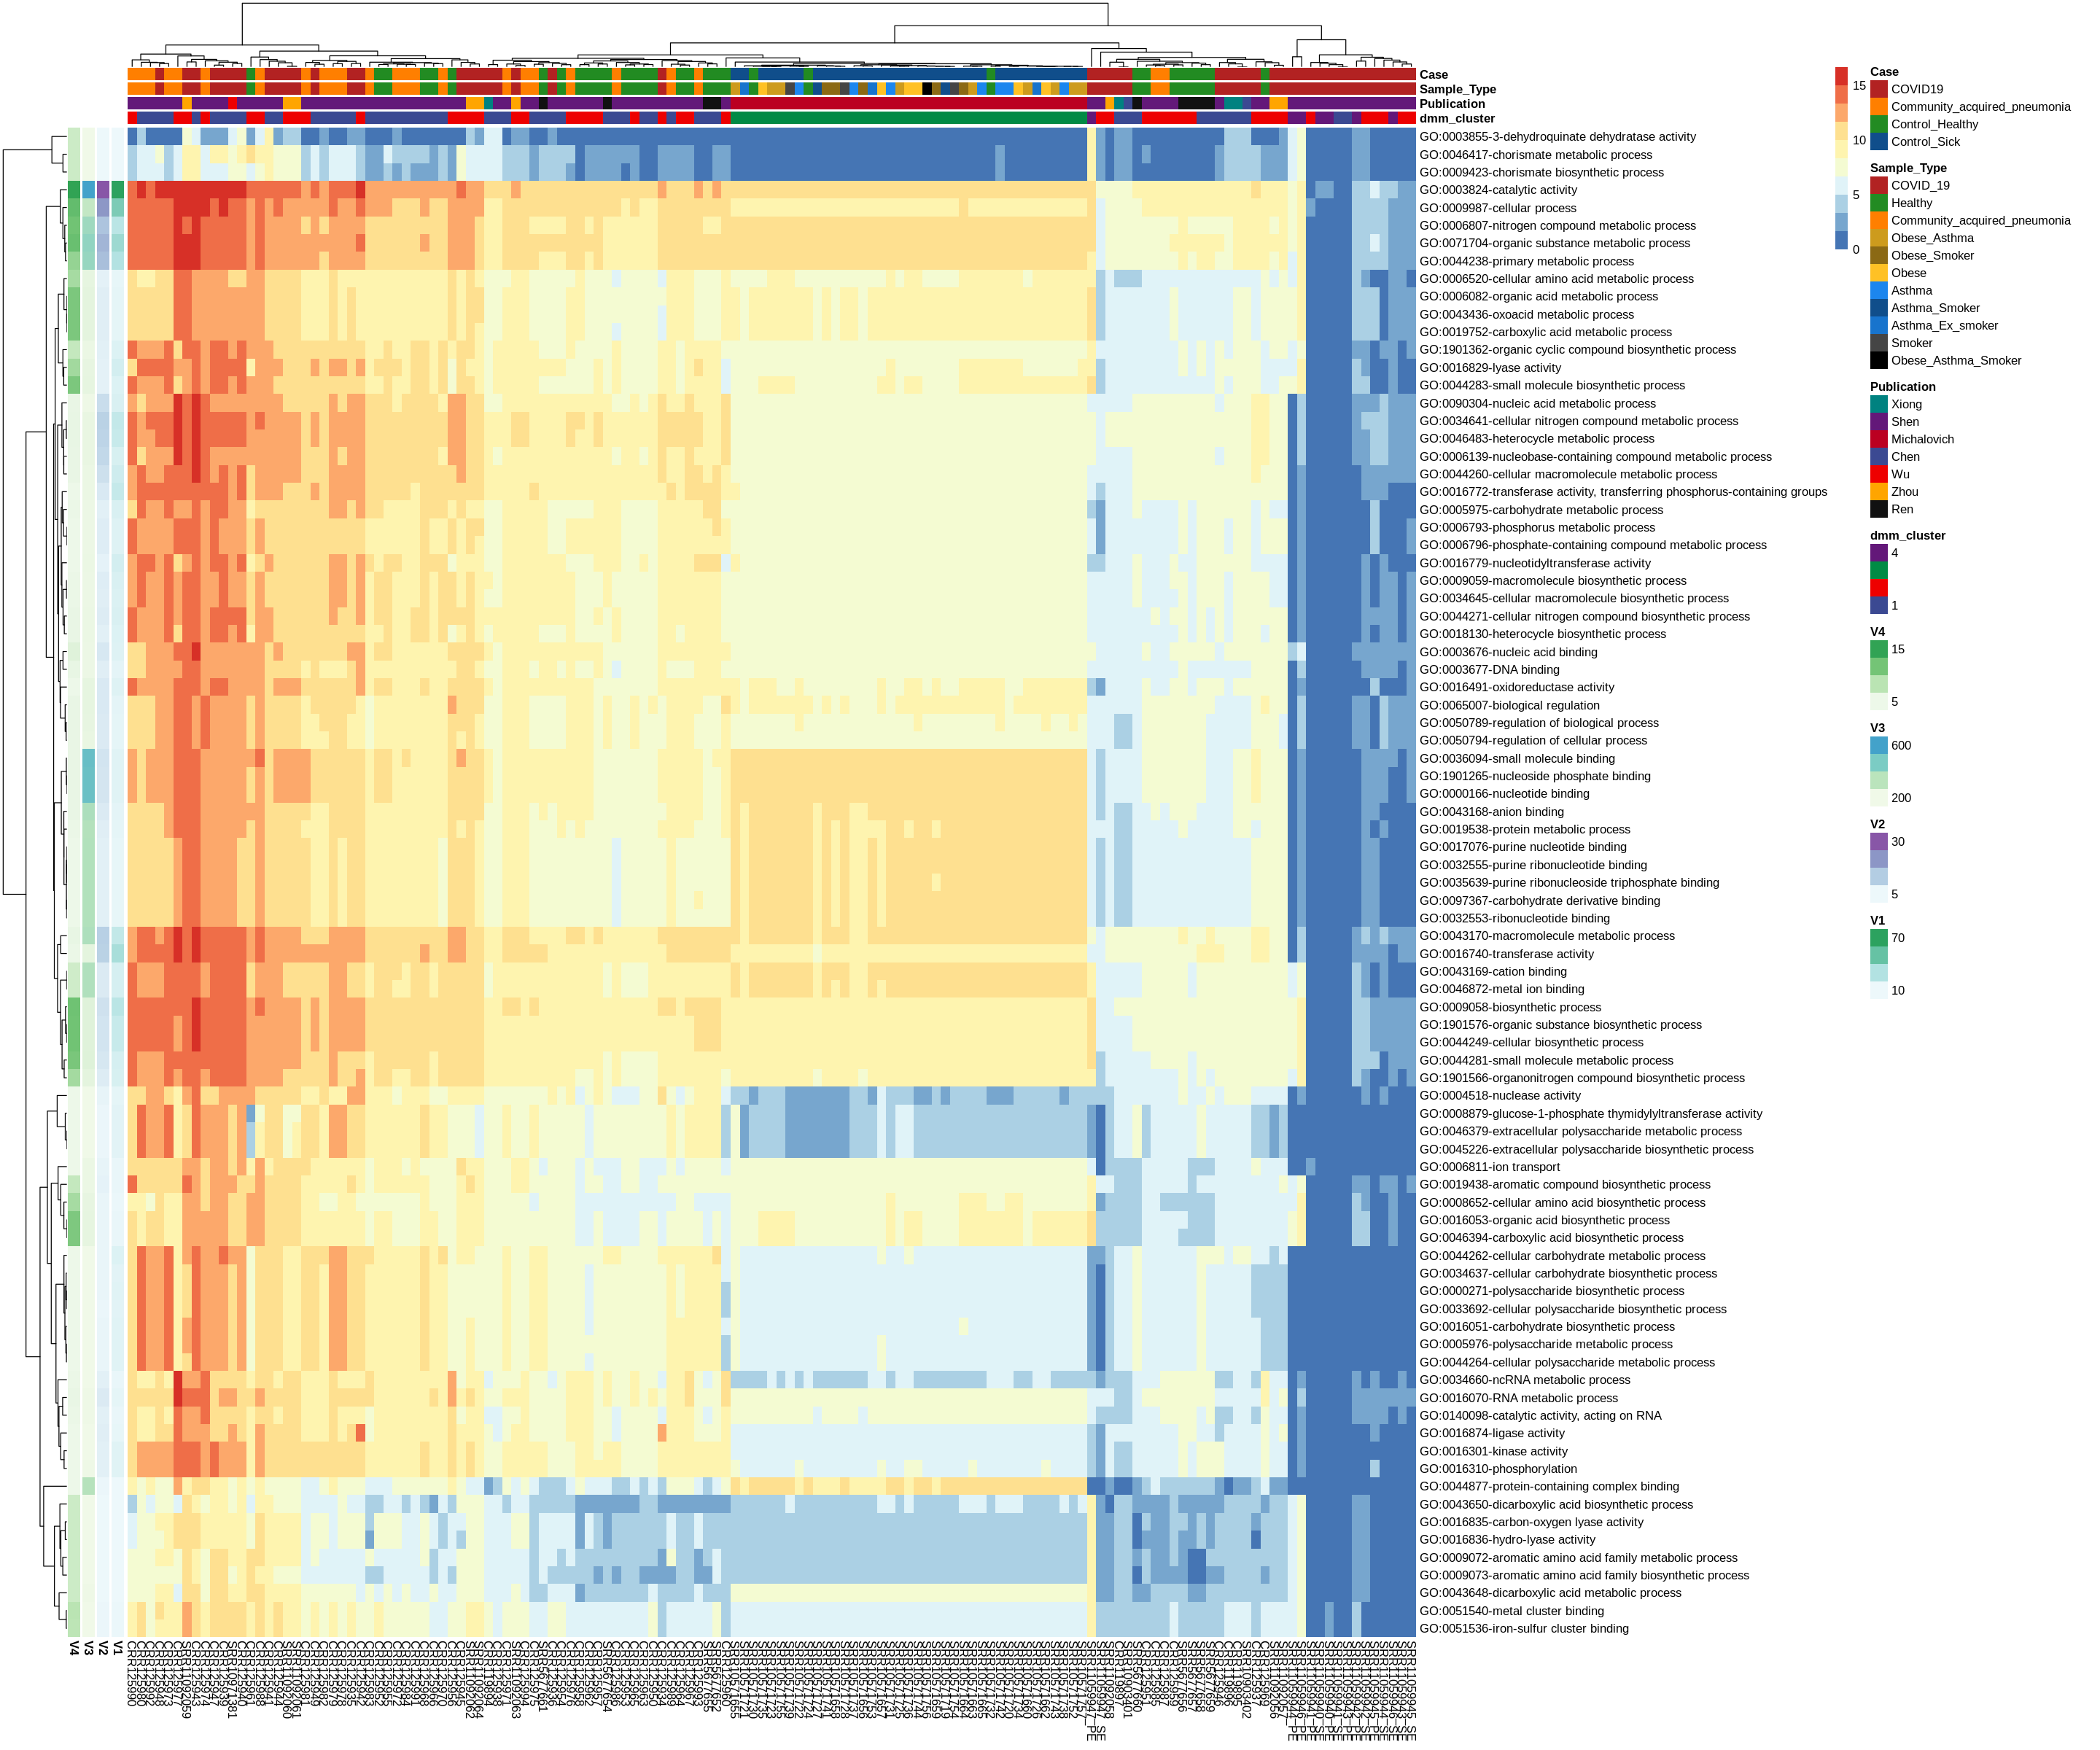

In [80]:
options(repr.plot.width=24, repr.plot.height=20)
xx <- pheatmap(mat = select2,
               color = colorRampPalette(rev(brewer.pal(n = 7, name ="RdYlBu")))(10),
               annotation_col=df,
               annotation_colors = ann_colors,
               clustering_distance_rows = "euclidean",
               clustering_distance_cols = "euclidean",
               annotation_row = df_row,
               cluster_row = T,
               cluster_col=T)

## OK GREAT JOB
### NEXT STEPS: 
#### REMOVE THE MIKALOVICH SAMPLES
#### ADD A COLUMN FOR OUTCOME ON THE HEATMAP

In [134]:
a

                              dmn
case                            1  2  3  4
  Community_acquired_pneumonia 16  9  0  0
  Control_Healthy              15 14  3  0
  Control_Sick                  0  0 36  0
  COVID19                      21 20  0  7

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



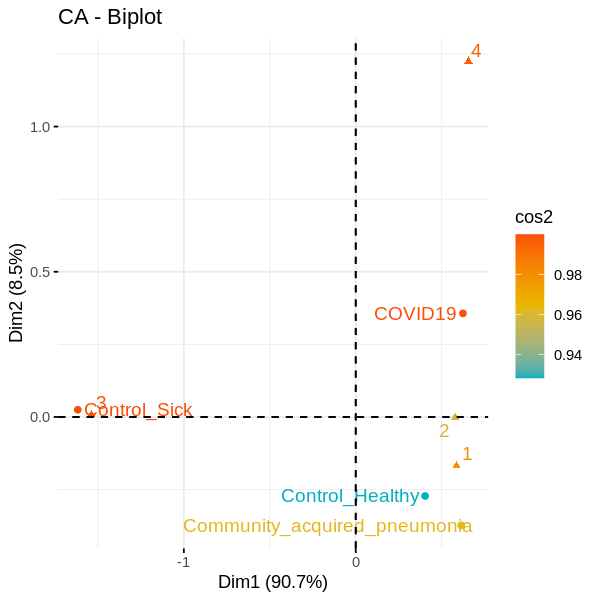

In [115]:
library('FactoMineR')
library('factoextra')
options(repr.plot.width=5, repr.plot.height=5)
a<-tally(~case+dmn,meta(bac_pseq_prune))
res.CA<-CA(a,graph=F)
#res.CA
fviz_ca_biplot(res.CA,
               repel=T,
               col.col="cos2",
               col.row="cos2",
               gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"))

In [81]:
##################ANYTHING BELOW THIS LINE IS TRASH FOR NOW###########
####################################################
# Correlation between dmm groups and cases
#################################################




library(matrixTests)
p<-psmelt(bac_pseq_prune)
dmn_sum<-p%>%
  select(Sample,OTU,dmn,Abundance)%>%
  group_by(OTU,dmn)%>%
  pivot_wider(id_cols = c(Sample,dmn), names_from = OTU,values_from = Abundance)
write.table(dmn_sum, "dmn_sum.tsv",sep="\t")
# an example with offsets from Venables & Ripley (2002, p.189)
dmn_case<-pairwise.wilcox.test(p$Abundance, p$case,p.adjust.method = "BH")
dmn_wilcox<-pairwise.wilcox.test(p$Abundance, p$dmn,p.adjust.method = "BH")


p$lg<-log1p(p$Abundance)
p$dmn<-as_factor(p$dmn)
p$case<-factor(x = p$case, levels = c("Control_Healthy","Control_Sick","COVID19"))


library(lmerTest)
library(lmer)
case_dmn_glm <- lmer(lg ~ dmn +(dmn|case),data = p)
f<-ls_means(case_dmn_glm)

# b<-glm( lg ~ dmn+case, data = p, family = gaussian)
library(mosaic)
msummary(b)
b$coefficients
c<-anova(b)
d<-aov(b)
e<-TukeyHSD(d)
library(lmerTest)
f<-ls_means(case_dmn_glm)

msummary(e$case)
e$case
mat<-dmn_sum[,3:length(dmn_sum)]
krus_dmn<-col_kruskalwallis(x =mat,g = dmn_sum$dmn)
welch_dmn<-col_oneway_welch(x=mat, g=dmn_sum$dmn)

krus_dmn_sig<-krus_dmn%>%filter(pvalue<0.01)%>%arrange(pvalue)
welch_dmn_sig<-welch_dmn%>%filter(pvalue<0.01)%>%arrange(pvalue)

TukeyHSD(welch_dmn_sig)
library(mosaic)
msummary(welch_dmn_sig)
dim(krus_dmn_sig)
dim(welch_dmn_sig)
krus_sig
write.table(krus,"krus_dmn.tsv",sep = "\t")

colnames(krus_sig)
colnames(krus_sig)
krus_sig_names<-intersect(rownames(krus_case_sig), rownames(krus_dmn_sig))
welch_sig_names<-intersect(rownames(welch_case_sig), rownames(welch_dmn_sig))
sig_names<-intersect(krus_sig_names,welch_sig_names)

ERROR: Error in library(matrixTests): there is no package called ‘matrixTests’
